# 05 ERP Analysis

## Overview
This notebook performs **Event-Related Potential (ERP) analysis** on preprocessed EEG data from the human-LLM alignment study.

**Purpose:**
- Extract and analyze neural responses to AI alignment stimuli
- Compare ERPs across alignment conditions (high/medium/low)
- Identify ERP components and assess data quality

**What it does:**
1. **Batch Processing**: Automatically processes all 21 sessions:
   - Loads preprocessed EEG data (from Notebook 04)
   - Extracts stimulus events from experiment CSV files
   - Creates epochs around each stimulus (-0.5 to +0.8 seconds)
   - Removes artifacts using AutoReject algorithm
   - Computes condition-averaged ERPs
   - Saves epochs and ERPs in MNE format
2. **Grand-Average Analysis**: Combines all sessions for publication-quality results
3. **Component Identification**: Detects and classifies ERP peaks (P1, N1, P2, P300, LPP, etc.)
4. **Quality Assessment**: Validates amplitude, SNR, and epoch counts

**Input:** 
- `session_XX-EEG-preprocessed.pkl` (from Notebook 04)
- Experiment CSV files with stimulus timing
- `session_mapping.csv` (from Notebook 01)

**Output:** 
- `session_XX-epochs-epo.fif`: Epoched data per session
- `session_XX-evoked-{condition}-ave.fif`: Condition-averaged ERPs
- `batch_processing_summary.csv`: Processing status for all sessions
- `grand_avg_erp_*.csv`: Grand-average data and figures
- `erp_peaks_session_XX.csv`: Peak detection results
- `erp_quality_session_XX.csv`: Quality metrics

**Next step:** Use results for statistical analysis and manuscript figures.

**Code Attribution:**
- ERP analysis workflow adapted from: Chiossi, F., Mayer, S., & Ou, C. (2024). MobileHCI 2024 Papers.
- OSF Repository: https://osf.io/fncj4/overview
- License: GNU General Public License (GPL) 3.0
- Code has been modified for batch processing and grand-average analysis.

---
## 1️⃣ SETUP: Import Libraries & Load Data

Initialize all necessary Python libraries and prepare data structures.


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
ERP Analysis Pipeline 
============================================
Comprehensive Event-Related Potential analysis including:
- Batch processing of 21 sessions
- Automated artifact rejection
- Peak detection and component identification
- Data quality assessment
"""

# ===== IMPORT SECTION =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import pickle
import re
import os
from pathlib import Path
from scipy.signal import find_peaks
from autoreject import AutoReject

# Configure plotting
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# ===== LOAD SESSION MAPPING AND IDENTIFY AVAILABLE DATA =====
print("="*80)
print("ERP ANALYSIS - DATA LOADING")
print("="*80)

# Load session mapping CSV
df_sessions = pd.read_csv('./session_mapping.csv')
df_matched = df_sessions[df_sessions['eeg_file'] != 'NO MATCH'].copy()

# Scan preprocessed directory for actual available sessions
preprocessed_dir = Path('./preprocessed')
available_sessions = []

for pkl_file in sorted(preprocessed_dir.glob('session_*-EEG-preprocessed.pkl')):
    match = re.search(r'session_(\d+)-EEG-preprocessed\.pkl', pkl_file.name)
    if match:
        session_id = int(match.group(1))
        available_sessions.append(session_id)

available_sessions = sorted(available_sessions)

print(f"\n✓ Session Mapping Loaded:")
print(f"  Total sessions in mapping: {len(df_sessions)}")
print(f"  Sessions with EEG data: {len(df_matched)}")
print(f"  Preprocessed sessions available: {len(available_sessions)}")
print(f"  Session IDs: {available_sessions}\n")


ERP ANALYSIS - DATA LOADING

✓ Session Mapping Loaded:
  Total sessions in mapping: 24
  Sessions with EEG data: 21
  Preprocessed sessions available: 21
  Session IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]



---
## 2️⃣ DIAGNOSTIC (Optional): Time Offset Analysis

**What it does**: Verifies that EEG and experiment timestamps are properly aligned.
**When to run**: First time only, or if timing issues suspected.

**Objective**: Determine the temporal relationship between EEG and experiment recordings

The EEG recording starts at `eeg_start_unix` (extracted from EEG filename) while the experiment begins at `el_recording.started_Unix` (from experiment CSV). These are aligned by calculating the offset between recordings. This is critical for correctly mapping stimulus event times to EEG samples.


In [2]:
# Calculate average time offset across all available sessions
print("="*70)
print("TIME OFFSET ANALYSIS - ALL SESSIONS")
print("="*70)

offsets = []

for sess_id in available_sessions:
    # Try to get session info from df_matched
    # First, try matching by index position (in case session_id corresponds to row position)
    if sess_id < len(df_matched):
        try:
            sess_info = df_matched.iloc[sess_id]
            exp_file_temp = sess_info['experiment_file']
            eeg_file_temp = sess_info['eeg_file']
            
            # Skip if NO MATCH
            if eeg_file_temp == 'NO MATCH':
                print(f"Session {sess_id:2d}: ⚠️ NO MATCH in session_mapping.csv (skipped)")
                continue
            
            # Load experiment data
            try:
                df_exp_temp = pd.read_csv(f'./Data/{exp_file_temp}', engine='python', on_bad_lines='skip')
                
                # Get timestamps
                exp_start = df_exp_temp['el_recording.started_Unix'].dropna().iloc[0]
                
                # Handle combined EEG files (e.g., "EEG_data_1764844642.csv + EEG_data_1764846180.csv")
                if '+' in eeg_file_temp:
                    # For combined files, use the first timestamp
                    eeg_file_first = eeg_file_temp.split('+')[0].strip()
                    eeg_start = int(eeg_file_first.split('_')[-1].replace('.csv', ''))
                else:
                    eeg_start = int(eeg_file_temp.split('_')[-1].replace('.csv', ''))
                
                # Calculate offset
                offset_sec = exp_start - eeg_start
                offset_min = offset_sec / 60
                
                offsets.append({
                    'session_id': sess_id,
                    'offset_seconds': offset_sec,
                    'offset_minutes': offset_min
                })
                
                print(f"Session {sess_id:2d}: {offset_min:6.2f} minutes ({offset_sec:7.1f} seconds)")
            except Exception as e:
                print(f"Session {sess_id:2d}: ⚠️ ERROR - {str(e)[:50]}")
        except Exception as e:
            print(f"Session {sess_id:2d}: ⚠️ LOOKUP ERROR - {str(e)[:50]}")
    else:
        print(f"Session {sess_id:2d}: ⚠️ Index {sess_id} out of range (only {len(df_matched)} sessions in mapping)")

# Calculate statistics
if len(offsets) > 0:
    df_offsets = pd.DataFrame(offsets)
    avg_offset_min = df_offsets['offset_minutes'].mean()
    std_offset_min = df_offsets['offset_minutes'].std()
    min_offset_min = df_offsets['offset_minutes'].min()
    max_offset_min = df_offsets['offset_minutes'].max()

    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    print(f"Average offset: {avg_offset_min:.2f} ± {std_offset_min:.2f} minutes")
    print(f"Range: {min_offset_min:.2f} to {max_offset_min:.2f} minutes")
    print(f"Total sessions analyzed: {len(offsets)}")

    # Check if offsets are consistent
    if std_offset_min > 1.0:
        print(f"\n⚠️ WARNING: High variability in time offsets (SD={std_offset_min:.2f} min)")
        print(f"   This suggests inconsistent timing between EEG and experiment recordings")
    else:
        print(f"\n✓ Time offsets are relatively consistent across sessions")
else:
    print("\n⚠️ ERROR: No valid offsets calculated. Check session mapping.")

TIME OFFSET ANALYSIS - ALL SESSIONS
Session  0:  38.80 minutes ( 2328.0 seconds)
Session  1:   1.48 minutes (   88.8 seconds)
Session  2: -12.94 minutes ( -776.3 seconds)
Session  3:  14.85 minutes (  891.0 seconds)
Session  4:   7.56 minutes (  453.7 seconds)
Session  5:  31.25 minutes ( 1875.2 seconds)
Session  6:   3.58 minutes (  214.6 seconds)
Session  7:   1.80 minutes (  107.8 seconds)
Session  8:   1.62 minutes (   97.0 seconds)
Session  9:   6.81 minutes (  408.7 seconds)
Session 10:   2.48 minutes (  148.5 seconds)
Session 11:   2.39 minutes (  143.4 seconds)
Session 12:  -4.86 minutes ( -291.5 seconds)
Session  6:   3.58 minutes (  214.6 seconds)
Session  7:   1.80 minutes (  107.8 seconds)
Session  8:   1.62 minutes (   97.0 seconds)
Session  9:   6.81 minutes (  408.7 seconds)
Session 10:   2.48 minutes (  148.5 seconds)
Session 11:   2.39 minutes (  143.4 seconds)
Session 12:  -4.86 minutes ( -291.5 seconds)
Session 13:   3.48 minutes (  208.9 seconds)
Session 14:   3.59 

---
## 3️⃣ MAIN: Batch Processing All Sessions (30-60 min)

**What it does**: Processes all 21 EEG sessions automatically
- Extracts stimulus events and timing
- Creates time-locked epochs around stimuli
- Applies artifact rejection (AutoReject)
- Computes condition-averaged ERPs

**Status**: Skips already processed sessions automatically

### Processing Pipeline (9-step per session):
1. **Load Session Info**: Extract experiment and EEG file references
2. **Load Preprocessed EEG**: Read ICA-processed data
3. **Load Experiment Events**: Extract stimulus times and condition labels
4. **Calculate Time Offset**: Synchronize EEG and experiment timestamps
5. **Create Events Array**: Convert stimulus times to EEG sample indices
6. **Create Epochs**: Extract time-locked windows around stimuli
7. **Artifact Rejection**: Remove contaminated trials (AutoReject)
8. **Compute ERPs**: Average epochs per condition
9. **Save Results**: Export epochs and ERPs in MNE format

### Estimated Runtime: 30-60 minutes depending on data volume

---


In [3]:
import os
from pathlib import Path

# Create results directory
os.makedirs('./results', exist_ok=True)

# Track processing statistics
batch_results = []

print("="*100)
print("BATCH PROCESSING - ALL SESSIONS")
print("="*100)
print(f"Total sessions to process: {len(available_sessions)}")
print(f"Session IDs: {available_sessions}")
print("="*100 + "\n")

# Check for already processed sessions
already_processed = []
for sess_id in available_sessions:
    # Check if epoch file exists (primary output)
    epoch_file = f'./preprocessed/session_{sess_id:02d}-epochs-epo.fif'
    if os.path.exists(epoch_file):
        already_processed.append(sess_id)

if already_processed:
    print(f"⏭️  SKIPPING {len(already_processed)} already processed sessions: {already_processed}")
    print(f"   (Delete epoch files to reprocess)")
    print("="*100 + "\n")

# Loop through all sessions
for idx, sess_id in enumerate(available_sessions):
    print(f"\n{'='*100}")
    print(f"[{idx+1}/{len(available_sessions)}] PROCESSING SESSION {sess_id:02d}")
    print(f"{'='*100}")
    
    # Skip if already processed
    if sess_id in already_processed:
        print(f"✓ Already processed - SKIPPING")
        batch_results.append({
            'session_id': sess_id,
            'status': 'SKIPPED (already processed)'
        })
        continue
    
    try:
        # === STEP 1: Load session info ===
        if sess_id >= len(df_matched):
            print(f"⚠️ Session {sess_id} index out of range - SKIPPING")
            continue
        
        sess_info = df_matched.iloc[sess_id]
        exp_file = sess_info['experiment_file']
        eeg_file = sess_info['eeg_file']
        
        # Skip if NO MATCH
        if eeg_file == 'NO MATCH':
            print(f"⚠️ NO MATCH in session_mapping.csv - SKIPPING")
            continue
        
        print(f"Experiment: {exp_file}")
        print(f"EEG: {eeg_file[:50]}...")  # Truncate for display
        
        # === STEP 2: Load preprocessed EEG ===
        try:
            with open(f'./preprocessed/session_{sess_id:02d}-EEG-preprocessed.pkl', 'rb') as f:
                raw = pickle.load(f)
            print(f"✓ Loaded EEG ({raw.get_data().shape[0]} channels, {raw.times[-1]:.1f}s)")
        except Exception as e:
            print(f"✗ Failed to load EEG: {str(e)[:50]} - SKIPPING")
            continue
        
        # === STEP 3: Load and extract events ===
        try:
            df_exp = pd.read_csv(f'./Data/{exp_file}', engine='python', on_bad_lines='skip')
            df_events = df_exp[df_exp['AI_Response.started'].notna()].copy()
            
            if len(df_events) == 0:
                print(f"⚠️ No stimulus events found - SKIPPING")
                continue
            
            print(f"✓ Loaded {len(df_events)} stimulus events")
            print(f"  Conditions: {df_events['Alignment'].value_counts().to_dict()}")
        except Exception as e:
            print(f"✗ Failed to load experiment: {str(e)[:50]} - SKIPPING")
            continue
        
        # === STEP 4: Calculate time offset ===
        try:
            exp_start_unix = df_exp['el_recording.started_Unix'].dropna().iloc[0]
            
            if '+' in eeg_file:
                eeg_file_first = eeg_file.split('+')[0].strip()
                eeg_start_unix = int(eeg_file_first.split('_')[-1].replace('.csv', ''))
            else:
                eeg_start_unix = int(eeg_file.split('_')[-1].replace('.csv', ''))
            
            time_offset = exp_start_unix - eeg_start_unix
            print(f"✓ Time offset: {time_offset/60:.2f} minutes")
        except Exception as e:
            print(f"✗ Failed to calculate offset: {str(e)[:50]} - SKIPPING")
            continue
        
        # === STEP 5: Create events array ===
        try:
            sfreq = raw.info['sfreq']
            event_times_eeg = df_events['AI_Response.started'].values + time_offset
            event_samples = (event_times_eeg * sfreq).astype(int)
            
            event_id = {'high': 1, 'medium': 2, 'low': 3}
            event_codes = df_events['Alignment'].map(event_id).values
            
            events = np.column_stack([event_samples, np.zeros(len(event_samples), dtype=int), event_codes])
            
            # Check validity
            valid_events = (events[:, 0] >= 0) & (events[:, 0] < len(raw.times))
            n_valid = valid_events.sum()
            print(f"✓ Created {n_valid}/{len(events)} valid events")
            
            if n_valid < 5:
                print(f"⚠️ Too few valid events ({n_valid}) - SKIPPING")
                continue
        except Exception as e:
            print(f"✗ Failed to create events: {str(e)[:50]} - SKIPPING")
            continue
        
        # === STEP 6: Create epochs ===
        try:
            from autoreject import AutoReject
            
            tmin, tmax = -0.5, 0.8
            baseline = (-0.5, -0.1)
            
            available_event_id = {k: v for k, v in event_id.items() if np.any(events[:, 2] == v)}
            
            epochs = mne.Epochs(raw, events, event_id=available_event_id, tmin=tmin, tmax=tmax,
                              baseline=None, preload=True, reject=None, verbose=False)
            
            n_epochs_before = len(epochs)
            print(f"✓ Created {n_epochs_before} epochs")
            
            # === STEP 7: Artifact rejection ===
            if n_epochs_before >= 5:
                try:
                    cv_folds = min(5, n_epochs_before)
                    ar = AutoReject(n_interpolate=[1, 2, 4], cv=cv_folds, random_state=42, n_jobs=1, verbose=False)
                    epochs_clean, _ = ar.fit_transform(epochs, return_log=True)
                except:
                    # Fallback to simple rejection
                    reject_threshold = dict(eeg=100e-6)
                    epochs_clean = epochs.copy().drop_bad(reject=reject_threshold)
                
                epochs_clean.apply_baseline(baseline)
                n_epochs_after = len(epochs_clean)
                print(f"✓ After artifact rejection: {n_epochs_after}/{n_epochs_before} epochs ({100*n_epochs_after/n_epochs_before:.1f}%)")
            else:
                epochs_clean = epochs
                n_epochs_after = n_epochs_before
            
            epochs = epochs_clean
        except Exception as e:
            print(f"✗ Failed to create/clean epochs: {str(e)[:50]} - SKIPPING")
            continue
        
        # === STEP 8: Compute ERPs ===
        try:
            evokeds = {}
            for condition in available_event_id.keys():
                if len(epochs[condition]) > 0:
                    evokeds[condition] = epochs[condition].average()
            
            if len(evokeds) == 0:
                print(f"⚠️ No valid ERPs computed - SKIPPING")
                continue
            
            print(f"✓ Computed {len(evokeds)} ERPs: {list(evokeds.keys())}")
        except Exception as e:
            print(f"✗ Failed to compute ERPs: {str(e)[:50]} - SKIPPING")
            continue
        
        # === STEP 9: Save results ===
        try:
            # Save epochs
            epochs.save(f'./preprocessed/session_{sess_id:02d}-epochs-epo.fif', overwrite=True)
            
            # Save ERPs
            for condition, evoked in evokeds.items():
                evoked.save(f'./preprocessed/session_{sess_id:02d}-evoked-{condition}-ave.fif', overwrite=True)
            
            print(f"✓ Saved epochs and {len(evokeds)} ERPs")
            
            # Export to CSV (Cz channel)
            if 'Cz' in epochs.ch_names:
                ch_idx = epochs.ch_names.index('Cz')
                
                df_erp = pd.DataFrame({'time_ms': evokeds[list(evokeds.keys())[0]].times * 1000})
                
                for condition, evoked in evokeds.items():
                    df_erp[condition] = evoked.data[ch_idx, :] * 1e6
                
                df_erp.to_csv(f'./results/erp_session_{sess_id:02d}_Cz.csv', index=False)
                print(f"✓ Exported ERP to CSV")
            
            # Track success
            batch_results.append({
                'session_id': sess_id,
                'exp_file': exp_file,
                'n_epochs': n_epochs_after,
                'conditions': list(evokeds.keys()),
                'status': 'SUCCESS'
            })
            
            print(f"✅ SESSION {sess_id:02d} COMPLETE")
            
        except Exception as e:
            print(f"✗ Failed to save results: {str(e)[:50]}")
            batch_results.append({
                'session_id': sess_id,
                'exp_file': exp_file,
                'status': f'ERROR: {str(e)[:30]}'
            })
    
    except Exception as e:
        print(f"✗✗✗ CRITICAL ERROR: {str(e)[:50]}")
        batch_results.append({
            'session_id': sess_id,
            'status': f'CRITICAL: {str(e)[:30]}'
        })

# === SUMMARY ===
print(f"\n{'='*100}")
print("BATCH PROCESSING COMPLETE")
print(f"{'='*100}")

df_batch_results = pd.DataFrame(batch_results)
successful = len(df_batch_results[df_batch_results['status'] == 'SUCCESS'])
print(f"\n✅ Successful: {successful}/{len(available_sessions)}")
print(f"{'='*100}\n")

print(df_batch_results[['session_id', 'status']].to_string(index=False))

# Save summary
df_batch_results.to_csv('./results/batch_processing_summary.csv', index=False)
print(f"\n✓ Summary saved to: ./results/batch_processing_summary.csv")

BATCH PROCESSING - ALL SESSIONS
Total sessions to process: 21
Session IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

⏭️  SKIPPING 19 already processed sessions: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
   (Delete epoch files to reprocess)


[1/21] PROCESSING SESSION 00
✓ Already processed - SKIPPING

[2/21] PROCESSING SESSION 01
✓ Already processed - SKIPPING

[3/21] PROCESSING SESSION 02
✓ Already processed - SKIPPING

[4/21] PROCESSING SESSION 03
Experiment: 01_human-llm-alignment_2025-11-27_09h44.35.888.csv
EEG: EEG_data_1764232442.csv...
✓ Loaded EEG (64 channels, 1310.6s)
✓ Loaded 7 stimulus events
  Conditions: {'low': 4, 'medium': 2, 'high': 1}
✓ Time offset: 14.85 minutes
✓ Created 2/7 valid events
⚠️ Too few valid events (2) - SKIPPING

[5/21] PROCESSING SESSION 04
Experiment: 01_human-llm-alignment_2025-11-27_10h18.29.349.csv
EEG: EEG_data_1764235080.csv...
✓ Loaded EEG (64 channels, 1310.6s)
✓ Loaded 7 stimulus ev

---
## 4️⃣ VISUALIZATION: Grand-Average ERP Comparisons

**What it does**: Combines all sessions to create publication-ready ERP waveforms
**Outputs**: 
- Figure1a: Overlaid comparison (direct condition overlay)
- Figure1b: Detailed 3×3 grid breakdown (electrodes × conditions)
- Topographic maps: Spatial distribution at 4 key latencies


LOADING BATCH PROCESSING RESULTS

✓ Loaded ERPs:
  High: 17 sessions
  Medium: 16 sessions
  Low: 15 sessions

COMPUTING GRAND AVERAGES

Identifying common channels ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a lega

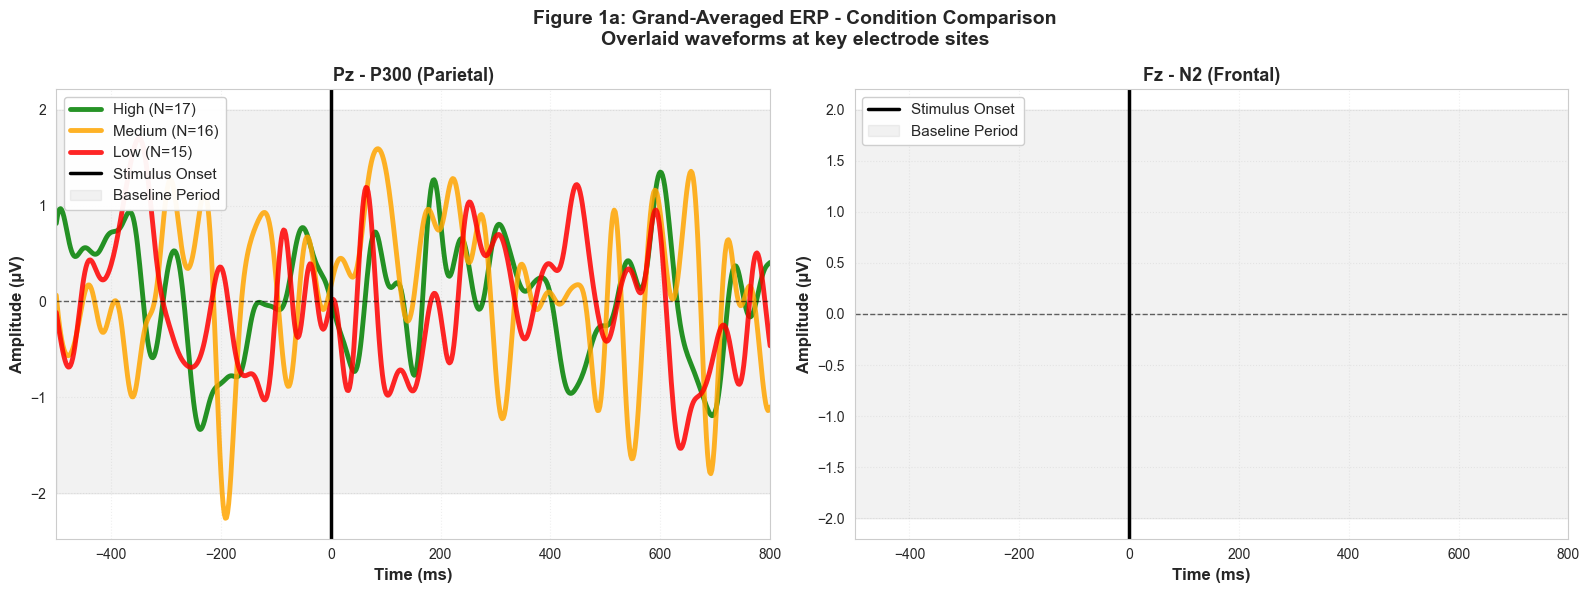

In [3]:
# LOAD BATCH PROCESSING RESULTS - Load all processed ERPs and compute grand averages

import warnings
warnings.filterwarnings('ignore')

print("="*100)
print("LOADING BATCH PROCESSING RESULTS")
print("="*100)

# Load all available evoked files and group by condition
evokeds_by_condition = {'high': [], 'medium': [], 'low': []}

for sess_id in available_sessions:
    for condition in ['high', 'medium', 'low']:
        evoked_file = f'./preprocessed/session_{sess_id:02d}-evoked-{condition}-ave.fif'
        if os.path.exists(evoked_file):
            try:
                evoked = mne.read_evokeds(evoked_file, verbose=False)[0]
                evokeds_by_condition[condition].append(evoked)
            except Exception as e:
                print(f"⚠️ Failed to load {evoked_file}: {str(e)[:50]}")

# Report loaded data
print(f"\n✓ Loaded ERPs:")
for condition, evokeds_list in evokeds_by_condition.items():
    print(f"  {condition.capitalize()}: {len(evokeds_list)} sessions")

# Compute grand averages
print(f"\n{'='*100}")
print("COMPUTING GRAND AVERAGES")
print(f"{'='*100}\n")

evoked_high = mne.grand_average(evokeds_by_condition['high']) if evokeds_by_condition['high'] else None
evoked_medium = mne.grand_average(evokeds_by_condition['medium']) if evokeds_by_condition['medium'] else None
evoked_low = mne.grand_average(evokeds_by_condition['low']) if evokeds_by_condition['low'] else None

# Plot ERPs for all conditions together
evokeds_to_plot = {}
if evoked_high is not None:
    evokeds_to_plot['High Alignment'] = evoked_high
    print(f"✓ High Alignment: Grand average of {len(evokeds_by_condition['high'])} sessions")
if evoked_medium is not None:
    evokeds_to_plot['Medium Alignment'] = evoked_medium
    print(f"✓ Medium Alignment: Grand average of {len(evokeds_by_condition['medium'])} sessions")
if evoked_low is not None:
    evokeds_to_plot['Low Alignment'] = evoked_low
    print(f"✓ Low Alignment: Grand average of {len(evokeds_by_condition['low'])} sessions")

if len(evokeds_to_plot) > 0:
    print(f"\n{'='*100}")
    print("GRAND-AVERAGE ERP VISUALIZATION - PANEL A: OVERLAID COMPARISON")
    print(f"{'='*100}\n")
    
    # Save grand averages first
    if evoked_high is not None:
        evoked_high.save('./results/grand_avg_high-ave.fif', overwrite=True)
    if evoked_medium is not None:
        evoked_medium.save('./results/grand_avg_medium-ave.fif', overwrite=True)
    if evoked_low is not None:
        evoked_low.save('./results/grand_avg_low-ave.fif', overwrite=True)
    
    print(f"✓ Grand averages saved to ./results/\n")
    
    # PANEL A: Overlaid comparison at key electrodes (Pz, Fz)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Figure 1a: Grand-Averaged ERP - Condition Comparison\nOverlaid waveforms at key electrode sites', 
                 fontsize=14, fontweight='bold')
    
    electrodes_to_plot = ['Pz', 'Fz']
    component_names = ['P300 (Parietal)', 'N2 (Frontal)']
    colors = {'High': 'green', 'Medium': 'orange', 'Low': 'red'}
    
    for ax_idx, (electrode, component_name) in enumerate(zip(electrodes_to_plot, component_names)):
        ax = axes[ax_idx]
        
        # Plot each condition
        for condition_name, evoked, color in [('High', evoked_high, 'green'),
                                               ('Medium', evoked_medium, 'orange'),
                                               ('Low', evoked_low, 'red')]:
            if evoked is not None and electrode in evoked.ch_names:
                ch_idx = evoked.ch_names.index(electrode)
                times_ms = evoked.times * 1000
                data_uv = evoked.data[ch_idx, :] * 1e6
                
                ax.plot(times_ms, data_uv, linewidth=3.5, label=f'{condition_name} (N={evoked.nave})',
                        color=color, alpha=0.85)
        
        # Reference lines and shading
        ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.6)
        ax.axvline(0, color='k', linestyle='-', linewidth=2.5, label='Stimulus Onset')
        ax.fill_between(times_ms, -2, 2, alpha=0.1, color='gray', label='Baseline Period')
        
        # Formatting
        ax.set_xlabel('Time (ms)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Amplitude (µV)', fontsize=12, fontweight='bold')
        ax.set_title(f'{electrode} - {component_name}', fontsize=13, fontweight='bold')
        ax.legend(fontsize=11, loc='upper left', framealpha=0.95)
        ax.grid(True, alpha=0.3, linestyle=':')
        ax.set_xlim([times_ms[0], times_ms[-1]])
    
    plt.tight_layout()
    plt.savefig('./results/Figure1a_erp_comparison_overlaid.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: Figure1a_erp_comparison_overlaid.png")
    plt.show()
    
else:
    print("⚠️ No ERPs available to plot - run batch processing first (Section 3)")


In [13]:
# Plot topographic maps at different time points (only for available conditions)
print(f"\n{'='*100}")
print("TOPOGRAPHIC MAPS - SPATIAL DISTRIBUTION ACROSS TIME")
print(f"{'='*100}\n")

# Critical time points for visualization
times_critical = [0.1, 0.2, 0.3, 0.5]  # 100ms, 200ms, 300ms, 500ms

# Plot each condition separately
if evoked_high is not None:
    print("High Alignment - Topographic Distribution:")
    fig = evoked_high.plot_topomap(times=times_critical, ch_type='eeg', show=False, 
                                    vmin=-5, vmax=5, cmap='RdBu_r')
    fig.suptitle('High Alignment - Spatial Distribution', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('./results/Topo_high_alignment.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: Topo_high_alignment.png")
    plt.show()

if evoked_medium is not None:
    print("Medium Alignment - Topographic Distribution:")
    fig = evoked_medium.plot_topomap(times=times_critical, ch_type='eeg', show=False,
                                      vmin=-5, vmax=5, cmap='RdBu_r')
    fig.suptitle('Medium Alignment - Spatial Distribution', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('./results/Topo_medium_alignment.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: Topo_medium_alignment.png")
    plt.show()

if evoked_low is not None:
    print("Low Alignment - Topographic Distribution:")
    fig = evoked_low.plot_topomap(times=times_critical, ch_type='eeg', show=False,
                                   vmin=-5, vmax=5, cmap='RdBu_r')
    fig.suptitle('Low Alignment - Spatial Distribution', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('./results/Topo_low_alignment.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: Topo_low_alignment.png")
    plt.show()

if evoked_high is None and evoked_medium is None and evoked_low is None:
    print("No conditions available to plot")


TOPOGRAPHIC MAPS - SPATIAL DISTRIBUTION ACROSS TIME

High Alignment - Topographic Distribution:


TypeError: Evoked.plot_topomap() got an unexpected keyword argument 'vmin'

---
## 5️⃣ ANALYSIS: Automatic Peak Detection

**What it does**: Identifies ERP component peaks automatically
**Method**: Finds positive/negative peaks within expected latency windows
**Output**: Peak latencies, amplitudes, channel names



GRAND-AVERAGE ERP VISUALIZATION - PANEL B: DETAILED BREAKDOWN

✓ Saved: Figure1b_erp_detailed_breakdown.png


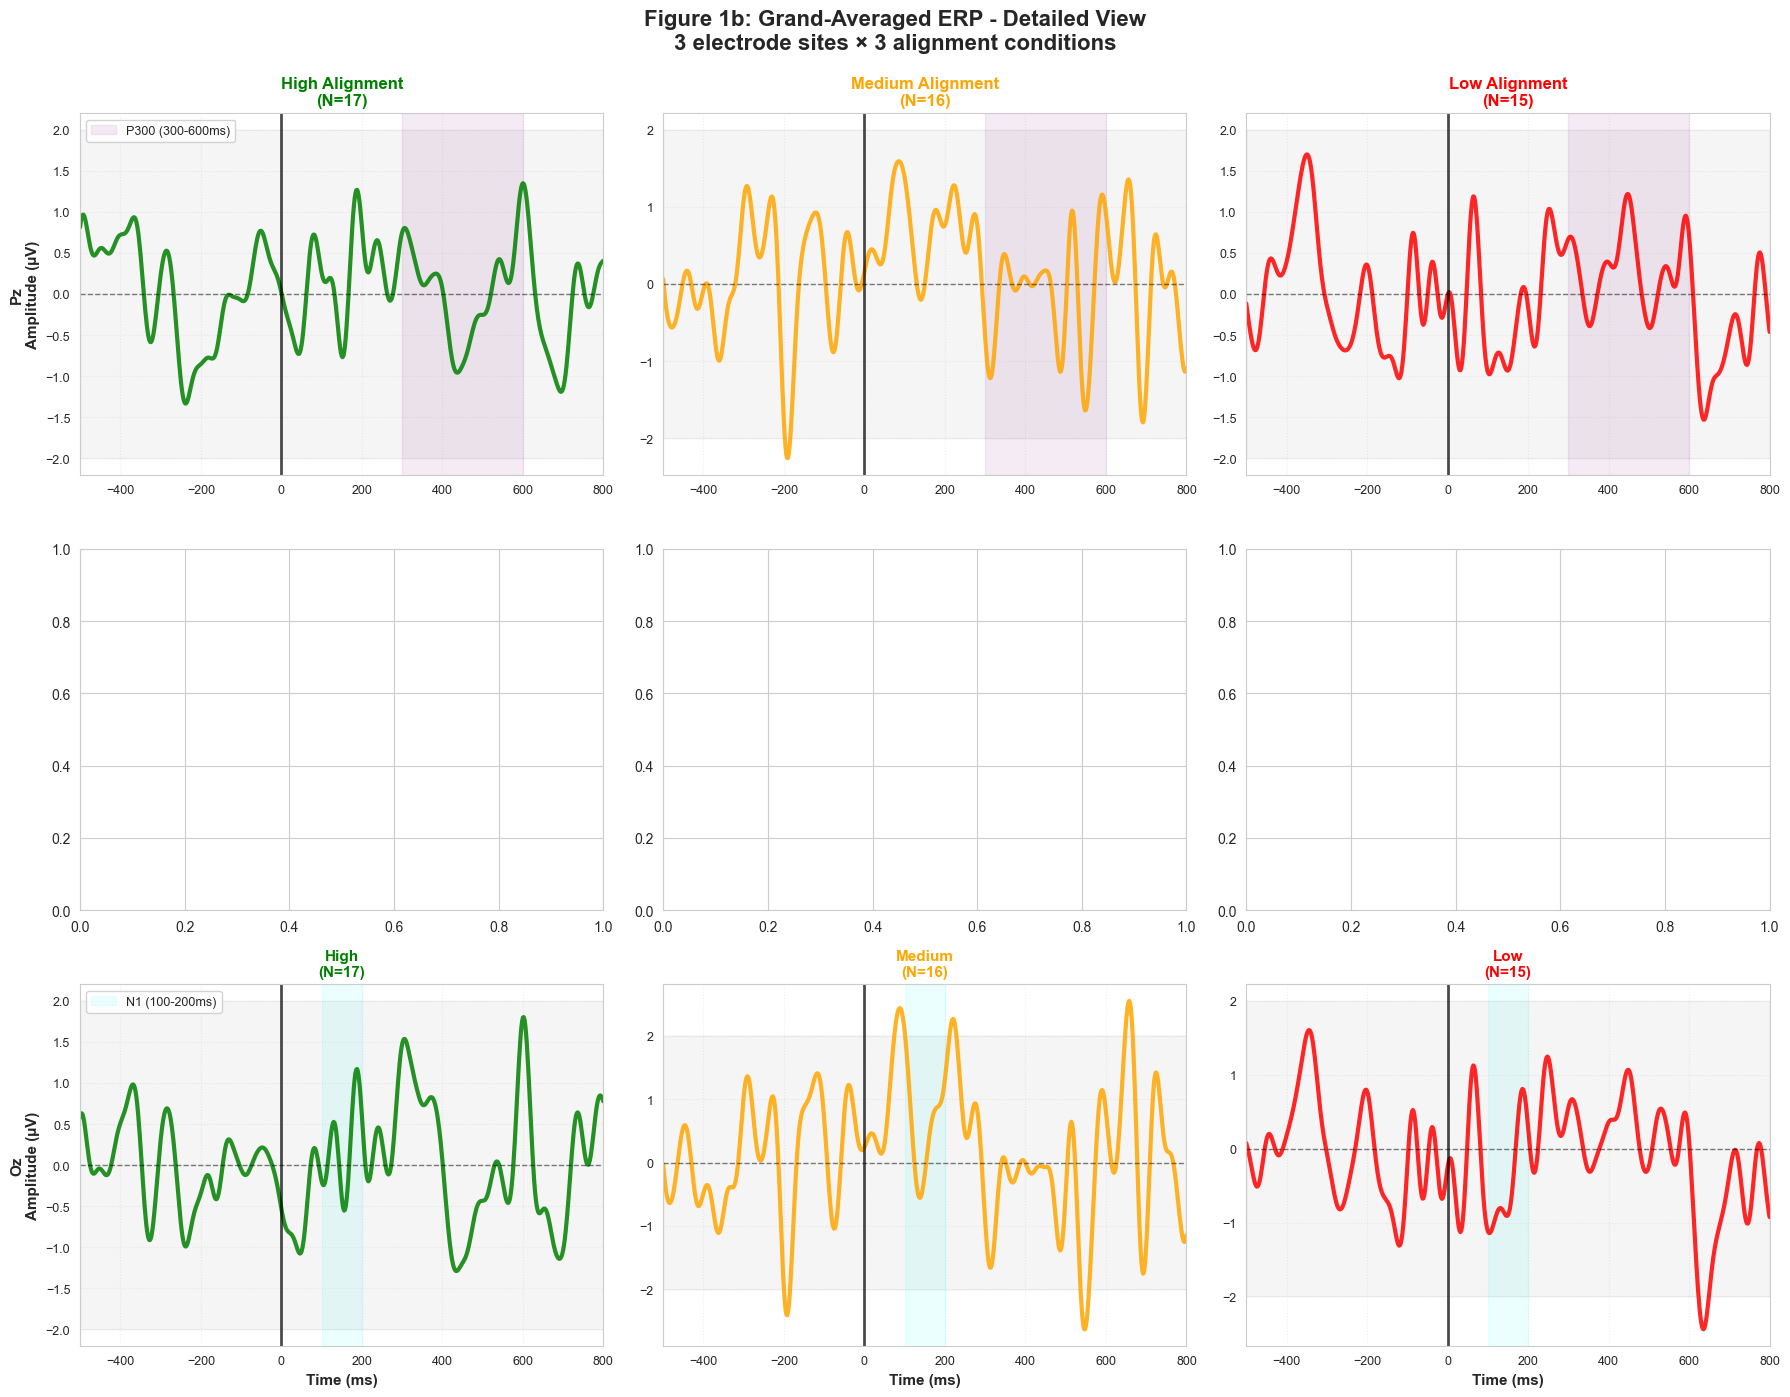

In [5]:
# PANEL B: Detailed separated view (3x3 grid: 3 electrodes × 3 conditions)
if len(evokeds_to_plot) > 0:
    print(f"\n{'='*100}")
    print("GRAND-AVERAGE ERP VISUALIZATION - PANEL B: DETAILED BREAKDOWN")
    print(f"{'='*100}\n")
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle('Figure 1b: Grand-Averaged ERP - Detailed View\n3 electrode sites × 3 alignment conditions', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    electrodes = ['Pz', 'Fz', 'Oz']  # Posterior, Frontal, Occipital
    conditions = [('High', evoked_high, 'green'),
                  ('Medium', evoked_medium, 'orange'),
                  ('Low', evoked_low, 'red')]
    
    for row_idx, electrode in enumerate(electrodes):
        for col_idx, (cond_name, evoked, color) in enumerate(conditions):
            ax = axes[row_idx, col_idx]
            
            if evoked is not None and electrode in evoked.ch_names:
                ch_idx = evoked.ch_names.index(electrode)
                times_ms = evoked.times * 1000
                data_uv = evoked.data[ch_idx, :] * 1e6
                
                # Plot waveform
                ax.plot(times_ms, data_uv, linewidth=3, color=color, alpha=0.85)
                
                # Reference lines
                ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5)
                ax.axvline(0, color='k', linestyle='-', linewidth=2, alpha=0.7)
                ax.fill_between(times_ms, -2, 2, alpha=0.08, color='gray')
                
                # Component highlighting
                if electrode == 'Pz':  # P300 window
                    ax.axvspan(300, 600, alpha=0.08, color='purple', label='P300 (300-600ms)')
                elif electrode == 'Fz':  # N2 window
                    ax.axvspan(200, 350, alpha=0.08, color='blue', label='N2 (200-350ms)')
                elif electrode == 'Oz':  # N1 window
                    ax.axvspan(100, 200, alpha=0.08, color='cyan', label='N1 (100-200ms)')
                
                # Format
                ax.grid(True, alpha=0.3, linestyle=':')
                ax.set_xlim([times_ms[0], times_ms[-1]])
                
                # Titles and labels
                if row_idx == 0:
                    ax.set_title(f'{cond_name} Alignment\n(N={evoked.nave})', 
                               fontsize=12, fontweight='bold', color=color)
                else:
                    ax.set_title(f'{cond_name}\n(N={evoked.nave})', 
                               fontsize=11, fontweight='bold', color=color)
                
                if col_idx == 0:
                    ax.set_ylabel(f'{electrode}\nAmplitude (µV)', fontsize=11, fontweight='bold')
                else:
                    ax.set_ylabel('')
                
                if row_idx == 2:
                    ax.set_xlabel('Time (ms)', fontsize=11, fontweight='bold')
                else:
                    ax.set_xlabel('')
                
                # Legend only on first column
                if col_idx == 0:
                    ax.legend(fontsize=9, loc='upper left', framealpha=0.85)
                
                ax.tick_params(labelsize=9)
    
    plt.tight_layout()
    plt.savefig('./results/Figure1b_erp_detailed_breakdown.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: Figure1b_erp_detailed_breakdown.png")
    plt.show()


In [6]:
from scipy.signal import find_peaks

def find_erp_peaks_auto(evoked, channel='Pz', tmin=0.0, tmax=0.8, height_threshold=None):
    """
    Automatically detects positive and negative peaks in ERP data.
    
    Parameters:
    -----------
    evoked : mne.Evoked
        Evoked object containing ERP data
    channel : str
        Channel name to analyze
    tmin, tmax : float
        Time window in seconds
    height_threshold : float or None
        Minimum absolute amplitude in µV (if None, uses data-driven threshold)
    
    Returns:
    --------
    dict with 'positive' and 'negative' peaks, each containing times and amplitudes
    """
    if evoked is None or channel not in evoked.ch_names:
        return None
    
    # Extract data
    evoked_crop = evoked.copy().crop(tmin=tmin, tmax=tmax)
    ch_idx = evoked_crop.ch_names.index(channel)
    data = evoked_crop.data[ch_idx, :] * 1e6  # Convert to µV
    times = evoked_crop.times
    
    # Set adaptive threshold if not provided
    if height_threshold is None:
        height_threshold = np.std(data) * 0.5  # Use 0.5 * standard deviation
    
    # Find positive peaks
    pos_peaks, pos_properties = find_peaks(data, height=height_threshold, distance=50)
    
    # Find negative peaks (invert signal)
    neg_peaks, neg_properties = find_peaks(-data, height=height_threshold, distance=50)
    
    results = {
        'positive': {
            'times': times[pos_peaks] * 1000,  # Convert to ms
            'amplitudes': data[pos_peaks],
            'indices': pos_peaks
        },
        'negative': {
            'times': times[neg_peaks] * 1000,
            'amplitudes': data[neg_peaks],
            'indices': neg_peaks
        },
        'channel': channel,
        'time_window': (tmin, tmax)
    }
    
    return results

# Analyze all available conditions
print("=== AUTOMATIC PEAK DETECTION ===\n")

channels_to_analyze = ['Pz', 'Cz', 'Fz']
peak_results = {}

for condition_name, evoked in [('High', evoked_high), ('Medium', evoked_medium), ('Low', evoked_low)]:
    if evoked is not None:
        print(f"\n{condition_name} Alignment:")
        print("-" * 50)
        
        peak_results[condition_name] = {}
        
        for ch in channels_to_analyze:
            if ch in evoked.ch_names:
                peaks = find_erp_peaks_auto(evoked, channel=ch, tmin=0.0, tmax=0.8)
                peak_results[condition_name][ch] = peaks
                
                print(f"\n  {ch}:")
                print(f"    Positive peaks: {len(peaks['positive']['times'])}")
                if len(peaks['positive']['times']) > 0:
                    for i, (t, amp) in enumerate(zip(peaks['positive']['times'], peaks['positive']['amplitudes'])):
                        print(f"      Peak {i+1}: {amp:6.2f} µV at {t:6.1f} ms")
                
                print(f"    Negative peaks: {len(peaks['negative']['times'])}")
                if len(peaks['negative']['times']) > 0:
                    for i, (t, amp) in enumerate(zip(peaks['negative']['times'], peaks['negative']['amplitudes'])):
                        print(f"      Peak {i+1}: {amp:6.2f} µV at {t:6.1f} ms")

=== AUTOMATIC PEAK DETECTION ===


High Alignment:
--------------------------------------------------

  Pz:
    Positive peaks: 5
      Peak 1:   0.72 µV at   80.0 ms
      Peak 2:   1.27 µV at  188.0 ms
      Peak 3:   0.80 µV at  306.0 ms
      Peak 4:   1.35 µV at  600.0 ms
      Peak 5:   0.37 µV at  736.0 ms
    Negative peaks: 4
      Peak 1:  -0.73 µV at   42.0 ms
      Peak 2:  -0.77 µV at  152.0 ms
      Peak 3:  -0.96 µV at  436.0 ms
      Peak 4:  -1.19 µV at  694.0 ms

  Cz:
    Positive peaks: 3
      Peak 1:   0.55 µV at  218.0 ms
      Peak 2:   0.45 µV at  464.0 ms
      Peak 3:   0.72 µV at  584.0 ms
    Negative peaks: 6
      Peak 1:  -0.57 µV at   58.0 ms
      Peak 2:  -0.18 µV at  174.0 ms
      Peak 3:  -0.51 µV at  288.0 ms
      Peak 4:  -0.19 µV at  406.0 ms
      Peak 5:  -0.15 µV at  514.0 ms
      Peak 6:  -0.59 µV at  702.0 ms

Medium Alignment:
--------------------------------------------------

  Pz:
    Positive peaks: 5
      Peak 1:   1.59 µV at   86

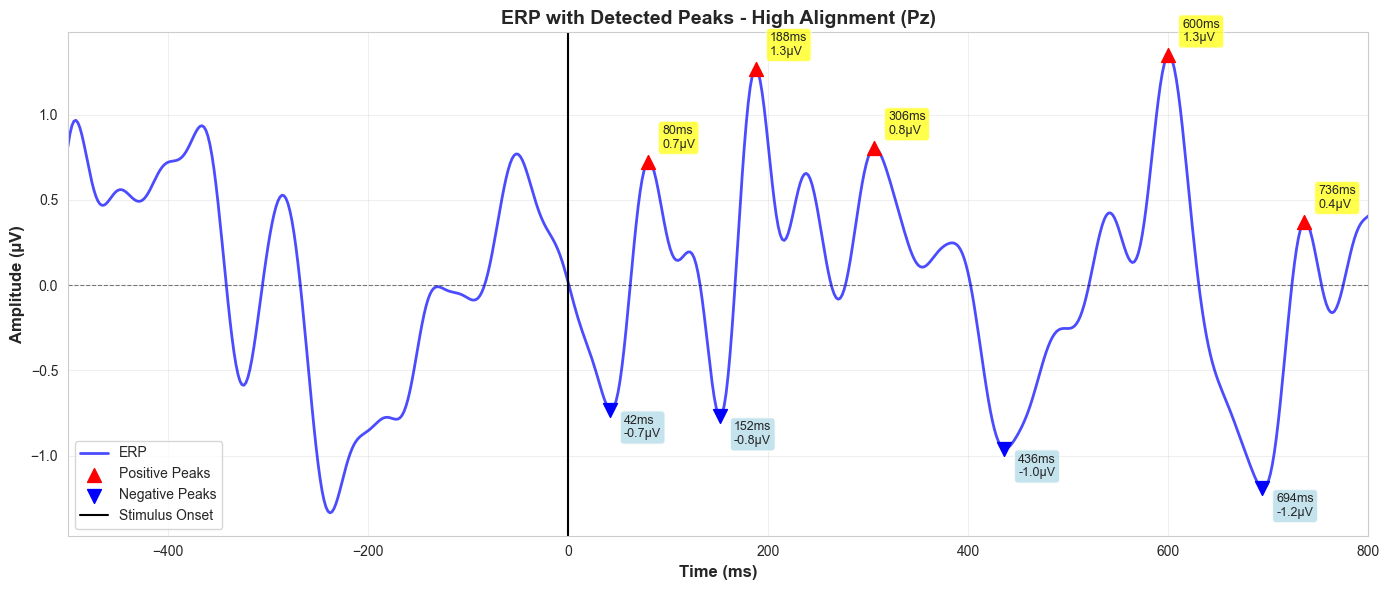

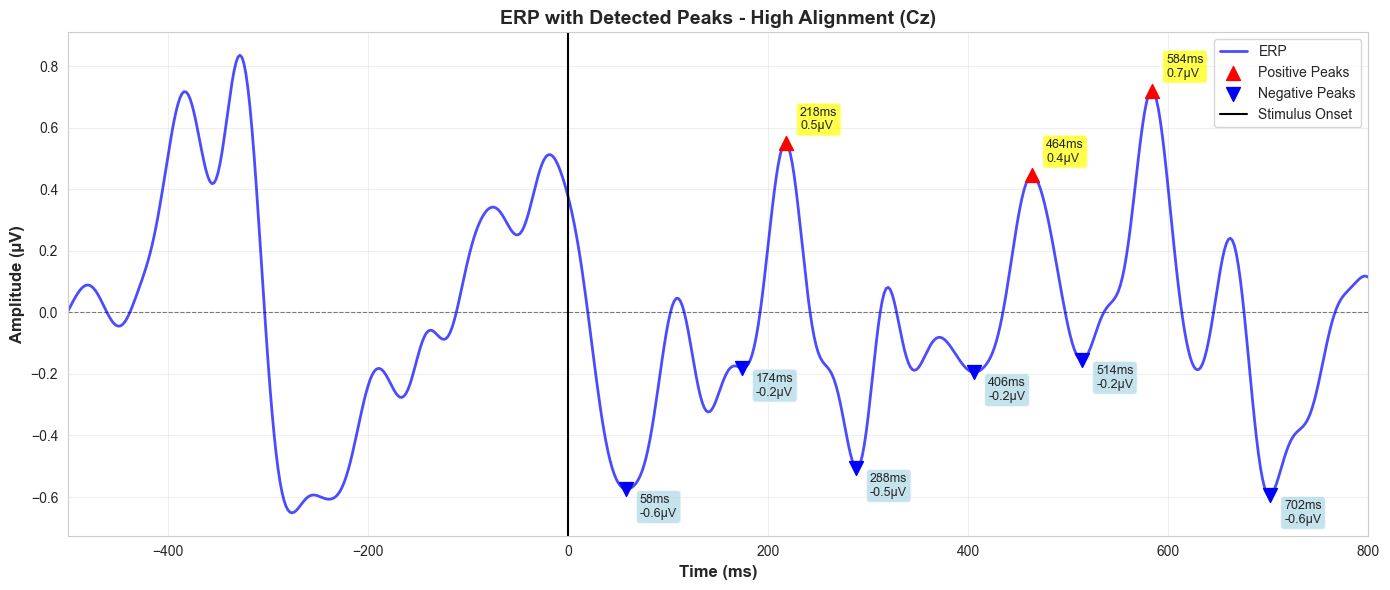

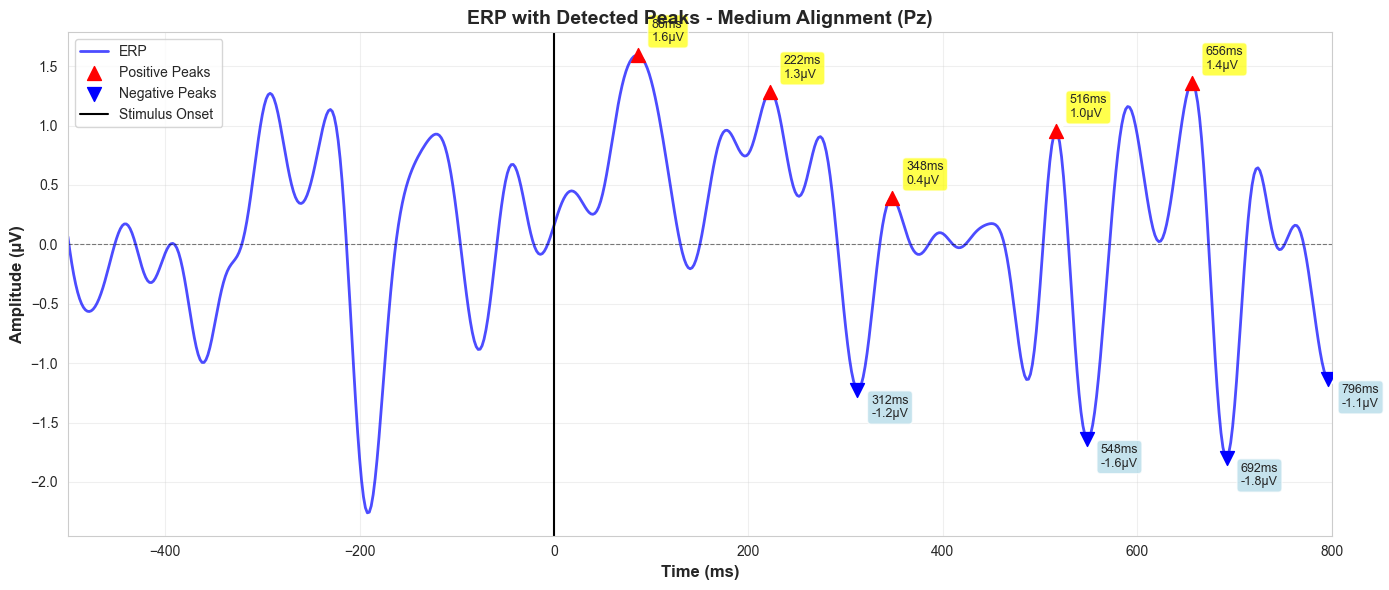

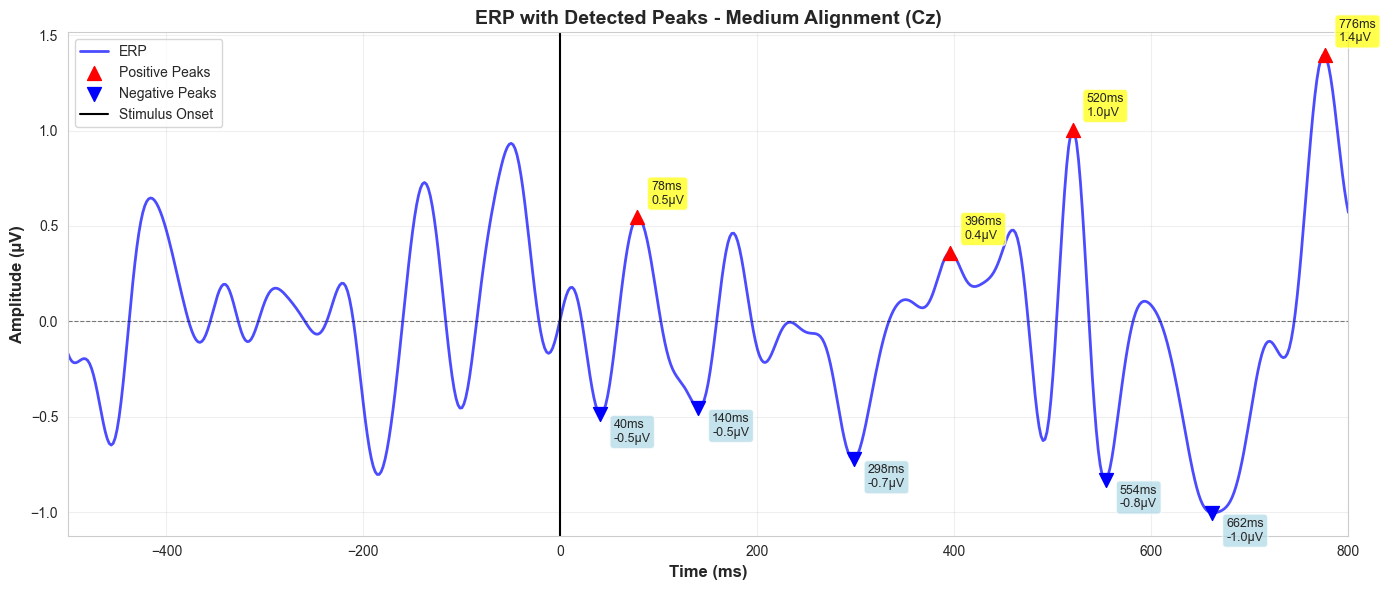

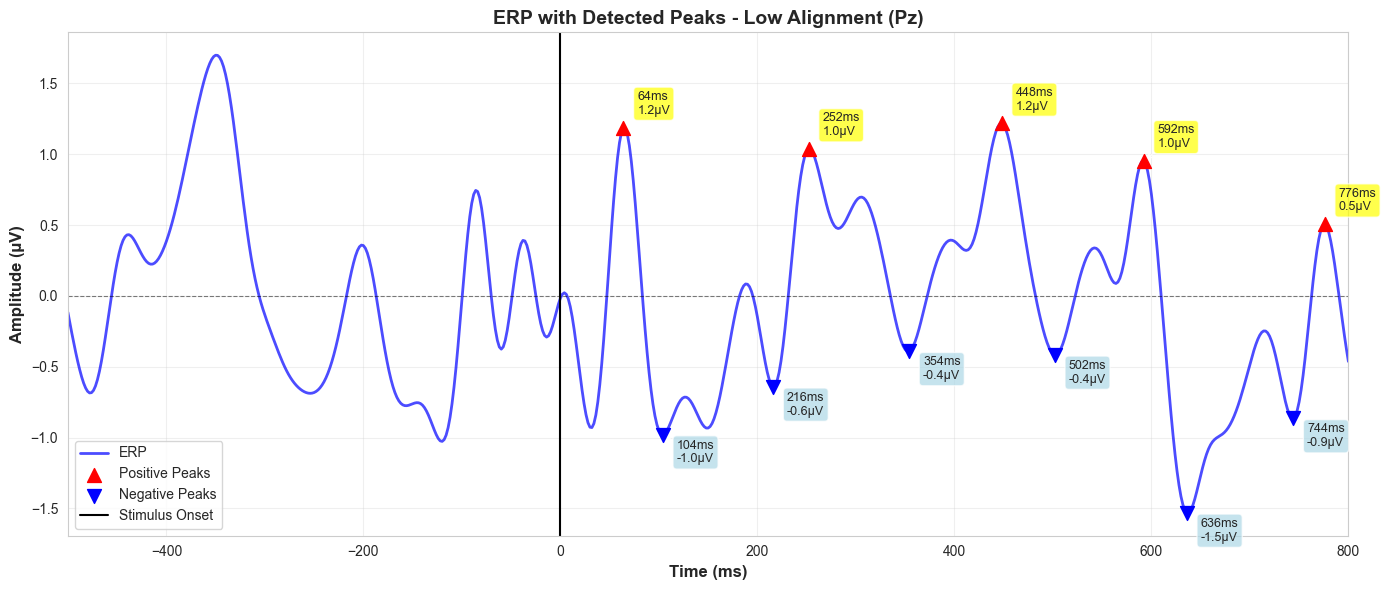

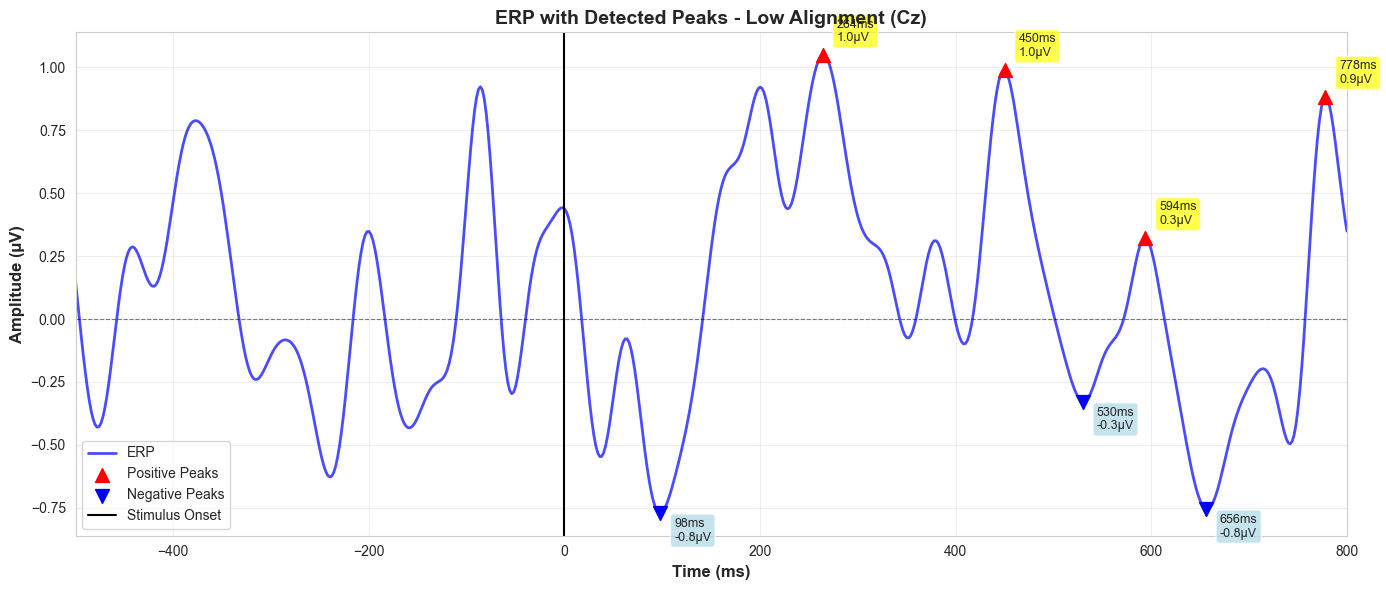

In [7]:
# Visualize detected peaks on ERP waveform
def plot_erp_with_peaks(evoked, peaks, channel='Pz', condition_name=''):
    """Plot ERP waveform with detected peaks marked."""
    if evoked is None or peaks is None:
        print(f"No data available for {condition_name}")
        return
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Get data
    ch_idx = evoked.ch_names.index(channel)
    times_ms = evoked.times * 1000
    data_uv = evoked.data[ch_idx, :] * 1e6
    
    # Plot ERP
    ax.plot(times_ms, data_uv, 'b-', linewidth=2, label='ERP', alpha=0.7)
    
    # Mark positive peaks
    if len(peaks['positive']['times']) > 0:
        ax.scatter(peaks['positive']['times'], peaks['positive']['amplitudes'], 
                  color='red', s=100, marker='^', zorder=5, label='Positive Peaks')
        # Annotate peaks
        for i, (t, amp) in enumerate(zip(peaks['positive']['times'], peaks['positive']['amplitudes'])):
            ax.annotate(f'{t:.0f}ms\n{amp:.1f}µV', 
                       xy=(t, amp), xytext=(10, 10),
                       textcoords='offset points', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Mark negative peaks
    if len(peaks['negative']['times']) > 0:
        ax.scatter(peaks['negative']['times'], peaks['negative']['amplitudes'],
                  color='blue', s=100, marker='v', zorder=5, label='Negative Peaks')
        # Annotate peaks
        for i, (t, amp) in enumerate(zip(peaks['negative']['times'], peaks['negative']['amplitudes'])):
            ax.annotate(f'{t:.0f}ms\n{amp:.1f}µV',
                       xy=(t, amp), xytext=(10, -20),
                       textcoords='offset points', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Reference lines
    ax.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(0, color='k', linestyle='-', linewidth=1.5, label='Stimulus Onset')
    
    # Formatting
    ax.set_xlabel('Time (ms)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Amplitude (µV)', fontsize=12, fontweight='bold')
    ax.set_title(f'ERP with Detected Peaks - {condition_name} ({channel})', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([times_ms[0], times_ms[-1]])
    
    plt.tight_layout()
    plt.show()

# Plot for each available condition
for condition_name, evoked in [('High Alignment', evoked_high), 
                                ('Medium Alignment', evoked_medium), 
                                ('Low Alignment', evoked_low)]:
    if evoked is not None and condition_name.split()[0] in peak_results:
        for ch in ['Pz', 'Cz']:
            if ch in evoked.ch_names:
                cond_key = condition_name.split()[0]
                if ch in peak_results[cond_key]:
                    plot_erp_with_peaks(evoked, peak_results[cond_key][ch], 
                                       channel=ch, condition_name=condition_name)

In [8]:
# Create summary table of all detected peaks
peak_summary_data = []

for condition_name in peak_results.keys():
    for ch in peak_results[condition_name].keys():
        peaks = peak_results[condition_name][ch]
        
        # Add positive peaks
        for i, (t, amp) in enumerate(zip(peaks['positive']['times'], peaks['positive']['amplitudes'])):
            peak_summary_data.append({
                'Condition': condition_name,
                'Channel': ch,
                'Polarity': 'Positive',
                'Peak_Number': i + 1,
                'Latency_ms': t,
                'Amplitude_uV': amp
            })
        
        # Add negative peaks
        for i, (t, amp) in enumerate(zip(peaks['negative']['times'], peaks['negative']['amplitudes'])):
            peak_summary_data.append({
                'Condition': condition_name,
                'Channel': ch,
                'Polarity': 'Negative',
                'Peak_Number': i + 1,
                'Latency_ms': t,
                'Amplitude_uV': amp
            })

if peak_summary_data:
    df_peaks = pd.DataFrame(peak_summary_data)
    df_peaks = df_peaks.sort_values(['Condition', 'Channel', 'Latency_ms'])
    
    print("\n=== PEAK SUMMARY TABLE ===")
    print(df_peaks.to_string(index=False))
    
    # Save to CSV
    os.makedirs('./results', exist_ok=True)
    df_peaks.to_csv(f'./results/erp_peaks_session_{session_id:02d}.csv', index=False)
    print(f"\n✓ Peak summary saved to: ./results/erp_peaks_session_{session_id:02d}.csv")
else:
    print("No peaks detected")


=== PEAK SUMMARY TABLE ===
Condition Channel Polarity  Peak_Number  Latency_ms  Amplitude_uV
     High      Cz Negative            1        58.0     -0.574290
     High      Cz Negative            2       174.0     -0.179941
     High      Cz Positive            1       218.0      0.549357
     High      Cz Negative            3       288.0     -0.505819
     High      Cz Negative            4       406.0     -0.194482
     High      Cz Positive            2       464.0      0.445056
     High      Cz Negative            5       514.0     -0.154606
     High      Cz Positive            3       584.0      0.721146
     High      Cz Negative            6       702.0     -0.593679
     High      Pz Negative            1        42.0     -0.729795
     High      Pz Positive            1        80.0      0.724343
     High      Pz Negative            2       152.0     -0.769989
     High      Pz Positive            2       188.0      1.269044
     High      Pz Positive            3       30

---
## 6️⃣ INTERPRETATION: Component Identification & Classification

**What it does**: Matches detected peaks to known ERP components
**Uses**: Component database (P300, N400, P600, FRN, N2, N1, LPP, Late Negativity)
**Matching criteria**: Latency window, polarity, electrode site
**Output**: Component names with confidence scores and descriptions


In [7]:
# Define known ERP components with typical characteristics
# Based on cognitive neuroscience literature
erp_components_db = {
    'P1': {
        'latency_range': (80, 130),    # ms
        'polarity': 'Positive',
        'typical_channels': ['O1', 'O2', 'Oz', 'P7', 'P8', 'Pz'],
        'description': 'Early visual processing',
        'category': 'Sensory'
    },
    'N1': {
        'latency_range': (100, 200),
        'polarity': 'Negative',
        'typical_channels': ['P7', 'P8', 'Pz', 'Oz'],
        'description': 'Visual attention and discrimination',
        'category': 'Sensory'
    },
    'P2': {
        'latency_range': (150, 275),
        'polarity': 'Positive',
        'typical_channels': ['Cz', 'Pz', 'Fz'],
        'description': 'Stimulus evaluation and attention',
        'category': 'Cognitive'
    },
    'N2': {
        'latency_range': (200, 350),
        'polarity': 'Negative',
        'typical_channels': ['Fz', 'FCz', 'Cz'],
        'description': 'Conflict monitoring, cognitive control',
        'category': 'Cognitive'
    },
    'P300': {
        'latency_range': (300, 600),
        'polarity': 'Positive',
        'typical_channels': ['Pz', 'Cz', 'CPz'],
        'description': 'Context updating, attention allocation, stimulus classification',
        'category': 'Cognitive/Decision-Making'
    },
    'N400': {
        'latency_range': (300, 500),
        'polarity': 'Negative',
        'typical_channels': ['Cz', 'Pz', 'C3', 'C4'],
        'description': 'Semantic processing, semantic expectancy violation, meaning integration',
        'category': 'Language/Semantic'
    },
    'P600': {
        'latency_range': (500, 900),
        'polarity': 'Positive',
        'typical_channels': ['Pz', 'Cz', 'CPz', 'P3', 'P4'],
        'description': 'Post-semantic processing, syntactic integration, revision/reanalysis, schema update',
        'category': 'Language/Semantic'
    },
    'FRN': {
        'latency_range': (250, 350),
        'polarity': 'Negative',
        'typical_channels': ['FCz', 'Fz', 'Cz'],
        'description': 'Feedback-Related Negativity, reward evaluation, error monitoring on feedback',
        'category': 'Reward/Feedback'
    },
    'LPP': {
        'latency_range': (400, 800),
        'polarity': 'Positive',
        'typical_channels': ['Pz', 'Cz', 'CPz'],
        'description': 'Late Positive Potential - emotional/motivational processing',
        'category': 'Affective'
    },
    'Late Negativity': {
        'latency_range': (500, 700),
        'polarity': 'Negative',
        'typical_channels': ['Cz', 'Fz'],
        'description': 'Late negative deflection (sustained negativity or N400 extension)',
        'category': 'Cognitive'
    }
}

def identify_erp_component(latency_ms, polarity, channel):
    """
    Identify which ERP component a peak might represent.
    
    Parameters:
    -----------
    latency_ms : float
        Peak latency in milliseconds
    polarity : str
        'Positive' or 'Negative'
    channel : str
        EEG channel name
    
    Returns:
    --------
    list of tuples: (component_name, confidence_score)
    """
    matches = []
    
    for comp_name, comp_info in erp_components_db.items():
        # Check polarity
        if comp_info['polarity'] != polarity:
            continue
        
        # Check latency range
        lat_min, lat_max = comp_info['latency_range']
        if not (lat_min <= latency_ms <= lat_max):
            continue
        
        # Calculate confidence based on channel match and latency fit
        confidence = 0.0
        
        # Channel match (50% of confidence)
        if channel in comp_info['typical_channels']:
            confidence += 0.5
        
        # Latency fit (50% of confidence) - how centered in the range
        lat_center = (lat_min + lat_max) / 2
        lat_range = lat_max - lat_min
        deviation = abs(latency_ms - lat_center) / lat_range
        latency_score = max(0, 0.5 * (1 - deviation))
        confidence += latency_score
        
        if confidence > 0:
            matches.append((comp_name, confidence))
    
    # Sort by confidence (highest first)
    matches.sort(key=lambda x: x[1], reverse=True)
    return matches

# Apply identification to all detected peaks
print("=== ERP COMPONENT IDENTIFICATION ===\n")

identified_components = []

for condition_name in peak_results.keys():
    for ch in peak_results[condition_name].keys():
        peaks = peak_results[condition_name][ch]
        
        # Process positive peaks
        for i, (t, amp) in enumerate(zip(peaks['positive']['times'], peaks['positive']['amplitudes'])):
            matches = identify_erp_component(t, 'Positive', ch)
            
            if matches:
                best_match, confidence = matches[0]
                identified_components.append({
                    'Condition': condition_name,
                    'Channel': ch,
                    'Latency_ms': t,
                    'Amplitude_uV': amp,
                    'Polarity': 'Positive',
                    'Identified_As': best_match,
                    'Confidence': confidence,
                    'Alternative_Matches': ', '.join([f"{m[0]}({m[1]:.2f})" for m in matches[1:3]]) if len(matches) > 1 else 'None',
                    'Description': erp_components_db[best_match]['description'],
                    'Category': erp_components_db[best_match]['category']
                })
        
        # Process negative peaks
        for i, (t, amp) in enumerate(zip(peaks['negative']['times'], peaks['negative']['amplitudes'])):
            matches = identify_erp_component(t, 'Negative', ch)
            
            if matches:
                best_match, confidence = matches[0]
                identified_components.append({
                    'Condition': condition_name,
                    'Channel': ch,
                    'Latency_ms': t,
                    'Amplitude_uV': amp,
                    'Polarity': 'Negative',
                    'Identified_As': best_match,
                    'Confidence': confidence,
                    'Alternative_Matches': ', '.join([f"{m[0]}({m[1]:.2f})" for m in matches[1:3]]) if len(matches) > 1 else 'None',
                    'Description': erp_components_db[best_match]['description'],
                    'Category': erp_components_db[best_match]['category']
                })

if identified_components:
    df_identified = pd.DataFrame(identified_components)
    df_identified = df_identified.sort_values(['Condition', 'Latency_ms'])
    
    print("\n" + "="*100)
    print("IDENTIFIED ERP COMPONENTS")
    print("="*100)
    print(df_identified[['Condition', 'Channel', 'Identified_As', 'Latency_ms', 
                        'Amplitude_uV', 'Confidence', 'Description']].to_string(index=False))
    
    # Save detailed results
    df_identified.to_csv(f'./results/erp_identified_session_{session_id:02d}.csv', index=False)
    print(f"\n✓ Identified components saved to: ./results/erp_identified_session_{session_id:02d}.csv")
    
    # Summary by component type
    print("\n" + "="*100)
    print("SUMMARY BY COMPONENT TYPE")
    print("="*100)
    summary = df_identified.groupby(['Condition', 'Identified_As']).agg({
        'Latency_ms': 'mean',
        'Amplitude_uV': 'mean',
        'Confidence': 'mean',
        'Channel': 'count'
    }).round(2)
    summary.columns = ['Avg_Latency_ms', 'Avg_Amplitude_uV', 'Avg_Confidence', 'N_Channels']
    print(summary)
else:
    print("No ERP components could be identified based on the current database.")

=== ERP COMPONENT IDENTIFICATION ===


IDENTIFIED ERP COMPONENTS
Condition Channel   Identified_As  Latency_ms  Amplitude_uV  Confidence                                                                         Description
     High      Pz              N1       152.0     -0.769989    0.990000                                                 Visual attention and discrimination
     High      Cz              N1       174.0     -0.179941    0.380000                                                 Visual attention and discrimination
     High      Pz              P2       188.0      1.269044    0.902000                                                   Stimulus evaluation and attention
     High      Cz              P2       218.0      0.549357    0.978000                                                   Stimulus evaluation and attention
     High      Cz              N2       288.0     -0.505819    0.956667                                              Conflict monitoring, cognitive control

---
## 7️⃣ STATISTICS: ERP Comparison Analysis

**What it does**: Compares ERP amplitudes across alignment conditions (Low, Medium, High)
**Statistical tests**: 
- Kruskal-Wallis H-test (non-parametric ANOVA)
- Mann-Whitney U pairwise comparisons  
- Cohen's d effect sizes
**Output**: 
- Figure2: Difference waves across electrodes
- Figure3: Bar plots with 95% confidence intervals & effect sizes
- CSV files with complete statistics



In [8]:
from scipy import stats

print("="*100)
print("ERP COMPARISON ANALYSIS: LOW vs. MEDIUM vs. HIGH ALIGNMENT")
print("="*100)

# Define analysis windows for key components
analysis_windows = {
    'N1 (80-150ms)': (0.080, 0.150, 'Oz'),
    'P2 (150-250ms)': (0.150, 0.250, 'Cz'),
    'FRN (250-350ms)': (0.250, 0.350, 'FCz'),
    'N2 (200-350ms)': (0.200, 0.350, 'Fz'),
    'N400 (300-500ms)': (0.300, 0.500, 'Cz'),
    'P300 (300-600ms)': (0.300, 0.600, 'Pz'),
    'P600 (500-900ms)': (0.500, 0.900, 'Pz'),
}

# Extract mean amplitudes in key windows
comparison_data = []

for window_name, (tmin, tmax, electrode) in analysis_windows.items():
    window_data = {
        'Component': window_name,
        'Electrode': electrode,
    }
    
    for condition_name, evoked, color in [('Low', evoked_low, 'red'),
                                           ('Medium', evoked_medium, 'orange'),
                                           ('High', evoked_high, 'green')]:
        if evoked is not None and electrode in evoked.ch_names:
            # Crop to window
            evoked_crop = evoked.copy().crop(tmin=tmin, tmax=tmax)
            ch_idx = evoked_crop.ch_names.index(electrode)
            
            # Extract data
            data_uv = evoked_crop.data[ch_idx, :] * 1e6
            mean_amp = np.mean(data_uv)
            peak_amp = np.max(np.abs(data_uv))
            
            window_data[f'{condition_name}_Mean_µV'] = mean_amp
            window_data[f'{condition_name}_Peak_µV'] = peak_amp
    
    comparison_data.append(window_data)

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("MEAN AMPLITUDE COMPARISON (µV) - ALL COMPONENTS")
print("="*100)
print(df_comparison.to_string(index=False))

# Save comparison table
df_comparison.to_csv('./results/erp_amplitude_comparison.csv', index=False)
print(f"\n✓ Comparison saved to: ./results/erp_amplitude_comparison.csv")

# Statistical testing: Point-wise paired comparison
print("\n" + "="*100)
print("STATISTICAL COMPARISON: CONDITION EFFECTS ON ERP AMPLITUDES")
print("="*100)

statistical_results = []

for window_name, (tmin, tmax, electrode) in analysis_windows.items():
    if electrode not in ['Pz', 'Cz', 'Fz', 'Oz', 'FCz']:
        continue
    
    # Extract single-trial data for each condition
    amplitudes_by_condition = {}
    
    for condition_name, evokeds_list in [('Low', evokeds_by_condition['low']),
                                         ('Medium', evokeds_by_condition['medium']),
                                         ('High', evokeds_by_condition['high'])]:
        
        condition_amps = []
        
        for evoked in evokeds_list:
            if electrode in evoked.ch_names:
                evoked_crop = evoked.copy().crop(tmin=tmin, tmax=tmax)
                ch_idx = evoked_crop.ch_names.index(electrode)
                data_uv = evoked_crop.data[ch_idx, :] * 1e6
                mean_amp = np.mean(data_uv)
                condition_amps.append(mean_amp)
        
        if condition_amps:
            amplitudes_by_condition[condition_name] = condition_amps
    
    # Only test if we have data from all conditions
    if len(amplitudes_by_condition) == 3:
        low_amps = amplitudes_by_condition['Low']
        medium_amps = amplitudes_by_condition['Medium']
        high_amps = amplitudes_by_condition['High']
        
        # Kruskal-Wallis test (non-parametric ANOVA)
        h_stat, p_value = stats.kruskal(low_amps, medium_amps, high_amps)
        
        # Effect size (eta-squared approximation)
        n_total = len(low_amps) + len(medium_amps) + len(high_amps)
        eta_squared = (h_stat / (n_total - 1)) if n_total > 1 else 0
        
        statistical_results.append({
            'Component': window_name,
            'Electrode': electrode,
            'H_Statistic': h_stat,
            'p_value': p_value,
            'Significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns',
            'Eta_Squared': eta_squared,
            'N_Sessions': len(low_amps)
        })
        
        # Pairwise comparisons (Mann-Whitney U)
        stat_low_med, p_low_med = stats.mannwhitneyu(low_amps, medium_amps)
        stat_med_high, p_med_high = stats.mannwhitneyu(medium_amps, high_amps)
        stat_low_high, p_low_high = stats.mannwhitneyu(low_amps, high_amps)
        
        print(f"\n{window_name} ({electrode}):")
        print(f"  Overall Kruskal-Wallis: H={h_stat:.2f}, p={p_value:.4f} {statistical_results[-1]['Significant']}")
        print(f"  Pairwise Comparisons:")
        print(f"    Low vs. Medium: p={p_low_med:.4f} {'*' if p_low_med < 0.05 else 'ns'}")
        print(f"    Medium vs. High: p={p_med_high:.4f} {'*' if p_med_high < 0.05 else 'ns'}")
        print(f"    Low vs. High: p={p_low_high:.4f} {'*' if p_low_high < 0.05 else 'ns'}")
        print(f"  Mean amplitudes: Low={np.mean(low_amps):.2f}µV, Medium={np.mean(medium_amps):.2f}µV, High={np.mean(high_amps):.2f}µV")

if statistical_results:
    df_stats = pd.DataFrame(statistical_results)
    df_stats.to_csv('./results/erp_statistical_comparison.csv', index=False)
    print(f"\n✓ Statistical results saved to: ./results/erp_statistical_comparison.csv")


ERP COMPARISON ANALYSIS: LOW vs. MEDIUM vs. HIGH ALIGNMENT

MEAN AMPLITUDE COMPARISON (µV) - ALL COMPONENTS
       Component Electrode  Low_Mean_µV  Low_Peak_µV  Medium_Mean_µV  Medium_Peak_µV  High_Mean_µV  High_Peak_µV
   N1 (80-150ms)        Oz    -0.838002     1.143098        0.893824        2.433373      0.086500      0.525987
  P2 (150-250ms)        Cz     0.644026     0.921533        0.033217        0.462216      0.081003      0.549357
 FRN (250-350ms)       FCz          NaN          NaN             NaN             NaN           NaN           NaN
  N2 (200-350ms)        Fz          NaN          NaN             NaN             NaN           NaN           NaN
N400 (300-500ms)        Cz     0.299521     0.989394        0.037608        0.713420      0.005146      0.445056
P300 (300-600ms)        Pz     0.301738     1.218221       -0.155413        1.639992      0.043877      1.348622
P600 (500-900ms)        Pz    -0.289247     1.530841       -0.028417        1.795300      0.002511   


AMPLITUDE COMPARISON: BAR PLOTS WITH CONFIDENCE INTERVALS & EFFECT SIZES

✓ Saved: Figure3_erp_amplitude_comparison.png


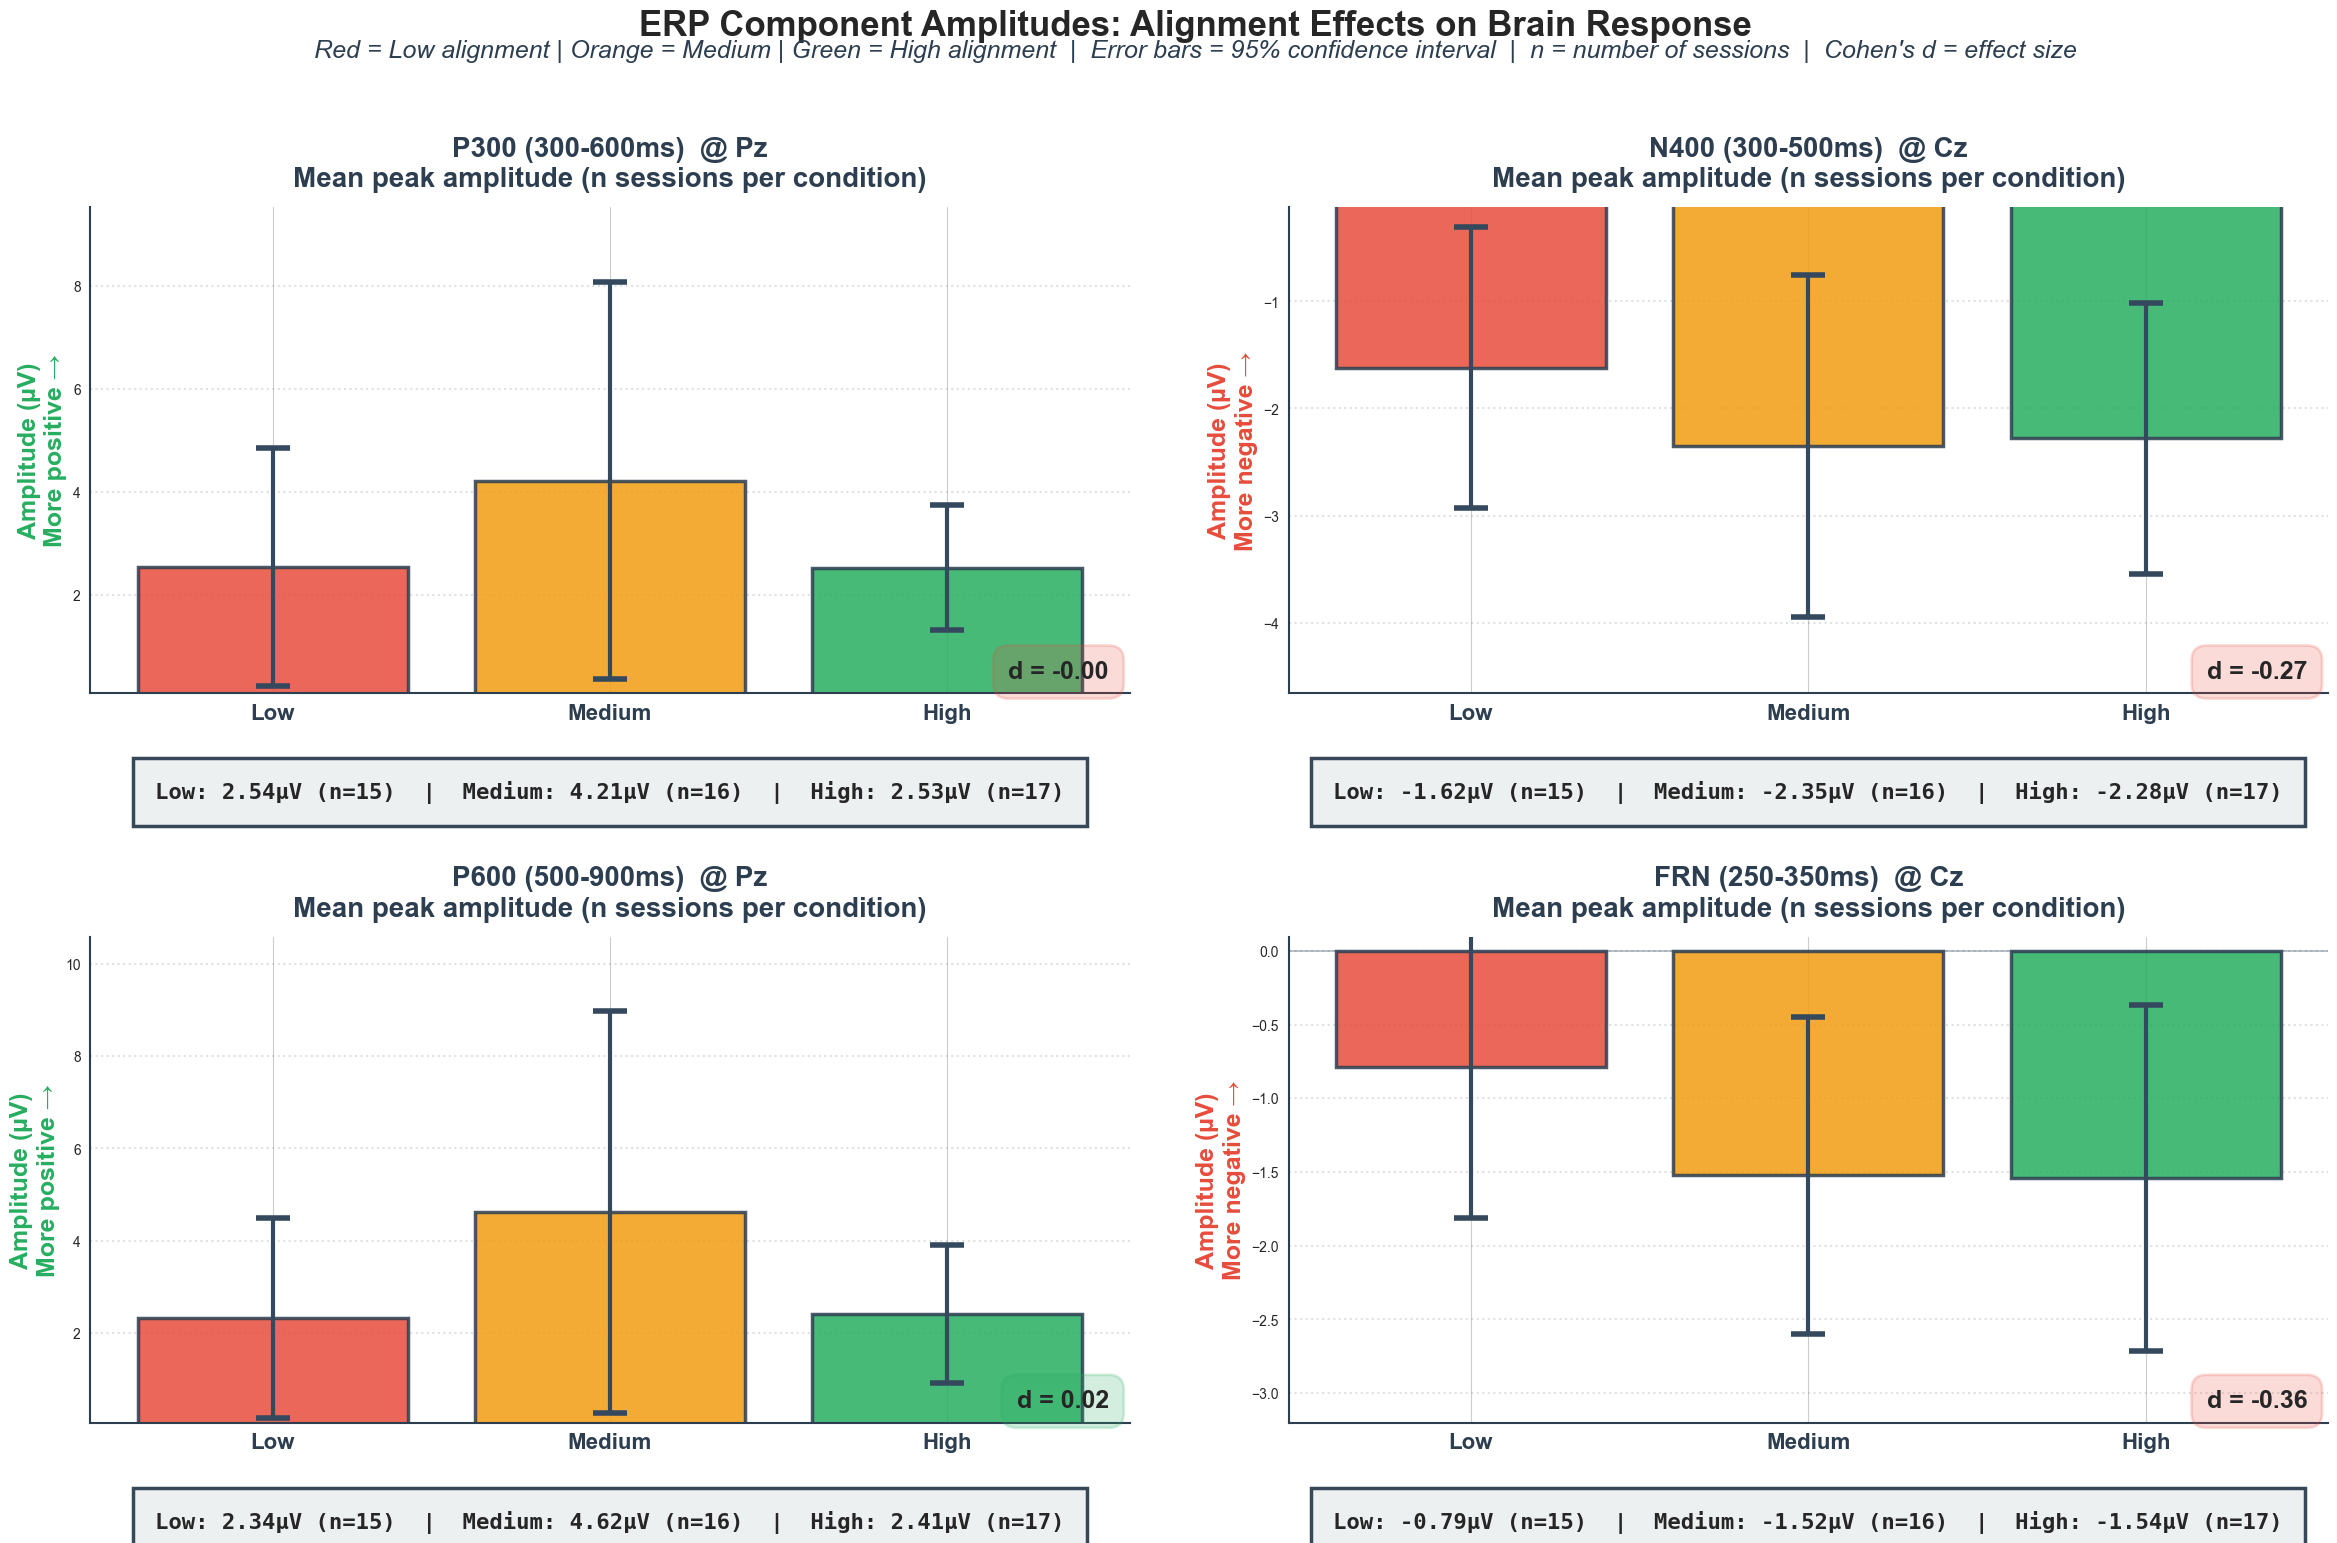


EFFECT SIZES (Cohen's d - High vs Low Alignment)
       Component Electrode  Cohens_d_High_vs_Low  N_Low  N_Medium  N_High
P300 (300-600ms)        Pz             -0.003585     15        16      17
N400 (300-500ms)        Cz             -0.272402     15        16      17
P600 (500-900ms)        Pz              0.022263     15        16      17
 FRN (250-350ms)        Cz             -0.361278     15        16      17

✓ Effect sizes saved to: ./results/erp_effect_sizes_cohens_d.csv

ERP COMPARISON ANALYSIS COMPLETE

Generated figures:
  • Figure2_erp_difference_waves.png - Overlay comparison with difference waves
  • Figure3_erp_amplitude_comparison.png - Bar plots with 95% CI and Cohen's d

Generated tables:
  • erp_amplitude_comparison.csv - Mean and peak amplitudes by condition
  • erp_statistical_comparison.csv - Kruskal-Wallis test results
  • erp_effect_sizes_cohens_d.csv - Cohen's d effect sizes (High vs Low)

Measurement Details:
  • Bars represent: Session means (grand-averaged

In [25]:
# Bar plot: Mean amplitudes in key components with 95% CI and effect sizes
print("\n" + "="*100)
print("AMPLITUDE COMPARISON: BAR PLOTS WITH CONFIDENCE INTERVALS & EFFECT SIZES")
print("="*100 + "\n")

# Calculate Cohen's d effect size
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size between two groups."""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / (pooled_std + 1e-10)

# Create figure with improved layout for user-friendliness
fig, axes = plt.subplots(2, 2, figsize=(24, 16))
fig.patch.set_facecolor('white')

# Improved main title with clear explanation
fig.suptitle('ERP Component Amplitudes: Alignment Effects on Brain Response', 
             fontsize=25, fontweight='bold', y=0.97)
fig.text(0.5, 0.94, 
         'Red = Low alignment | Orange = Medium | Green = High alignment  |  Error bars = 95% confidence interval  |  n = number of sessions  |  Cohen\'s d = effect size',
         ha='center', fontsize=18, style='italic', color='#2c3e50', weight='normal')

key_components = [
    ('P300 (300-600ms)', 0.300, 0.600, 'Pz', 'positive'),
    ('N400 (300-500ms)', 0.300, 0.500, 'Cz', 'negative'),
    ('P600 (500-900ms)', 0.500, 0.900, 'Pz', 'positive'),
    ('FRN (250-350ms)', 0.250, 0.350, 'Cz', 'negative')
]

effect_sizes_summary = []

for idx, (comp_name, tmin, tmax, electrode, polarity) in enumerate(key_components):
    ax = axes[idx // 2, idx % 2]
    
    conditions = ['Low', 'Medium', 'High']
    colors_bar = ['#e74c3c', '#f39c12', '#27ae60']  # Professional color palette (red, orange, green)
    amplitudes = []
    ci_lower = []
    ci_upper = []
    sample_sizes = []
    all_condition_data = []
    
    for condition_name, evokeds_list in [('Low', evokeds_by_condition['low']),
                                         ('Medium', evokeds_by_condition['medium']),
                                         ('High', evokeds_by_condition['high'])]:
        
        session_amps = []
        
        for evoked in evokeds_list:
            if electrode in evoked.ch_names:
                evoked_crop = evoked.copy().crop(tmin=tmin, tmax=tmax)
                ch_idx = evoked_crop.ch_names.index(electrode)
                data_uv = evoked_crop.data[ch_idx, :] * 1e6
                
                # For negative components, find the minimum (most negative)
                # For positive components, find the maximum
                if polarity == 'negative':
                    peak_amp = np.min(data_uv)  # Most negative value
                else:
                    peak_amp = np.max(data_uv)  # Most positive value
                
                session_amps.append(peak_amp)
        
        all_condition_data.append(session_amps)
        
        if session_amps:
            n = len(session_amps)
            mean_amp = np.mean(session_amps)
            std_err = np.std(session_amps, ddof=1) / np.sqrt(n)
            
            # 95% Confidence Interval using t-distribution
            from scipy.stats import t
            t_crit = t.ppf(0.975, df=n-1)  # Two-tailed, alpha=0.05
            ci = t_crit * std_err
            
            amplitudes.append(mean_amp)
            ci_lower.append(mean_amp - ci)
            ci_upper.append(mean_amp + ci)
            sample_sizes.append(n)
        else:
            amplitudes.append(0)
            ci_lower.append(0)
            ci_upper.append(0)
            sample_sizes.append(0)
    
    # Create bar plot with 95% CI - improved styling
    x_pos = np.arange(len(conditions))
    ci_errors = [np.array(amplitudes) - np.array(ci_lower), 
                 np.array(ci_upper) - np.array(amplitudes)]
    
    # Better bar plot aesthetics
    bars = ax.bar(x_pos, amplitudes, yerr=ci_errors, capsize=12, 
                   color=colors_bar, alpha=0.85, edgecolor='#2c3e50', linewidth=2.5,
                   error_kw={'linewidth': 3, 'ecolor': '#34495e', 'capthick': 4})
    
    # Add value labels on bars with sample size - single line below subplot
    # Create a single info line at the bottom of each subplot
    info_text_parts = []
    for i, (amp, n) in enumerate(zip(amplitudes, sample_sizes)):
        info_text_parts.append(f'{conditions[i]}: {amp:.2f}µV (n={n})')
    
    info_text = '  |  '.join(info_text_parts)
    
    # Place the info text below the subplot with fully bordered rectangle
    ax.text(0.5, -0.18, info_text, transform=ax.transAxes,
           ha='center', va='top', fontsize=16, fontweight='bold', family='monospace',
           bbox=dict(boxstyle='square,pad=1.0', facecolor='#ecf0f1', 
                    edgecolor='#2c3e50', alpha=0.95, linewidth=2.5))
    
    # Calculate and display effect sizes (Cohen's d) - more prominent
    if len(all_condition_data[0]) > 0 and len(all_condition_data[2]) > 0:
        d_low_high = cohens_d(all_condition_data[2], all_condition_data[0])  # High vs Low
        effect_sizes_summary.append({
            'Component': comp_name,
            'Electrode': electrode,
            'Cohens_d_High_vs_Low': d_low_high,
            'N_Low': sample_sizes[0],
            'N_Medium': sample_sizes[1],
            'N_High': sample_sizes[2]
        })
        
        # Add effect size annotation with better styling
        effect_color = '#27ae60' if d_low_high > 0 else '#e74c3c'  # Green if positive, red if negative
        ax.text(0.98, 0.02, f"d = {d_low_high:.2f}", 
               transform=ax.transAxes, fontsize=18, fontweight='bold',
               ha='right', va='bottom',
               bbox=dict(boxstyle='round,pad=0.6', facecolor=effect_color, 
                        alpha=0.2, edgecolor=effect_color, linewidth=2))
    
    # Better axis formatting
    ax.set_xticks(x_pos)
    ax.set_xticklabels(conditions, fontsize=16, fontweight='bold', color='#2c3e50')
    
    # Y-axis label with polarity indication
    if polarity == 'negative':
        ax.set_ylabel('Amplitude (µV)\nMore negative →', fontsize=18, fontweight='bold', color='#e74c3c')
    else:
        ax.set_ylabel('Amplitude (µV)\nMore positive →', fontsize=18, fontweight='bold', color='#27ae60')
    
    # Clear, descriptive subplot title
    ax.set_title(f'{comp_name}  @ {electrode}\nMean peak amplitude (n sessions per condition)', 
                fontsize=20, fontweight='bold', pad=15, color='#2c3e50')
    
    # Grid for readability
    ax.grid(True, alpha=0.25, axis='y', linestyle=':', linewidth=1.5, color='#7f8c8d')
    ax.axhline(0, color='#34495e', linestyle='-', linewidth=1.2, alpha=0.4)
    
    # Set y-axis limits appropriately with padding
    if polarity == 'negative':
        all_vals = ci_lower + ci_upper
        min_val = min(all_vals) * 1.18  # More negative at bottom
        max_val = max(ci_upper) * 0.4   # Close to zero at top
        ax.set_ylim([min_val, max_val])
    else:
        all_vals = ci_lower + ci_upper
        min_val = min(ci_lower) * 0.4   # Close to zero at bottom
        max_val = max(all_vals) * 1.18  # More positive at top
        ax.set_ylim([min_val, max_val])
    
    # Improve axis appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('#2c3e50')
    ax.spines['bottom'].set_color('#2c3e50')

plt.tight_layout(rect=[0, 0, 1, 0.93], h_pad=3.5, w_pad=2.5)
plt.savefig('./results/Figure3_erp_amplitude_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: Figure3_erp_amplitude_comparison.png")
plt.show()

# Save effect sizes to table
if effect_sizes_summary:
    df_effect_sizes = pd.DataFrame(effect_sizes_summary)
    df_effect_sizes.to_csv('./results/erp_effect_sizes_cohens_d.csv', index=False)
    print("\n" + "="*100)
    print("EFFECT SIZES (Cohen's d - High vs Low Alignment)")
    print("="*100)
    print(df_effect_sizes.to_string(index=False))
    print(f"\n✓ Effect sizes saved to: ./results/erp_effect_sizes_cohens_d.csv")

print("\n" + "="*100)
print("ERP COMPARISON ANALYSIS COMPLETE")
print("="*100)
print("\nGenerated figures:")
print("  • Figure2_erp_difference_waves.png - Overlay comparison with difference waves")
print("  • Figure3_erp_amplitude_comparison.png - Bar plots with 95% CI and Cohen's d")
print("\nGenerated tables:")
print("  • erp_amplitude_comparison.csv - Mean and peak amplitudes by condition")
print("  • erp_statistical_comparison.csv - Kruskal-Wallis test results")
print("  • erp_effect_sizes_cohens_d.csv - Cohen's d effect sizes (High vs Low)")
print("\nMeasurement Details:")
print("  • Bars represent: Session means (grand-averaged ERPs)")
print("  • Error bars: 95% Confidence Intervals (t-distribution)")
print("  • Amplitude metric: Peak value within component time window")
print("    - Positive components: Maximum amplitude (P300, P600)")
print("    - Negative components: Minimum amplitude (N400, FRN, N2, N1)")
print("  • Effect size: Cohen's d comparing High vs Low alignment conditions")


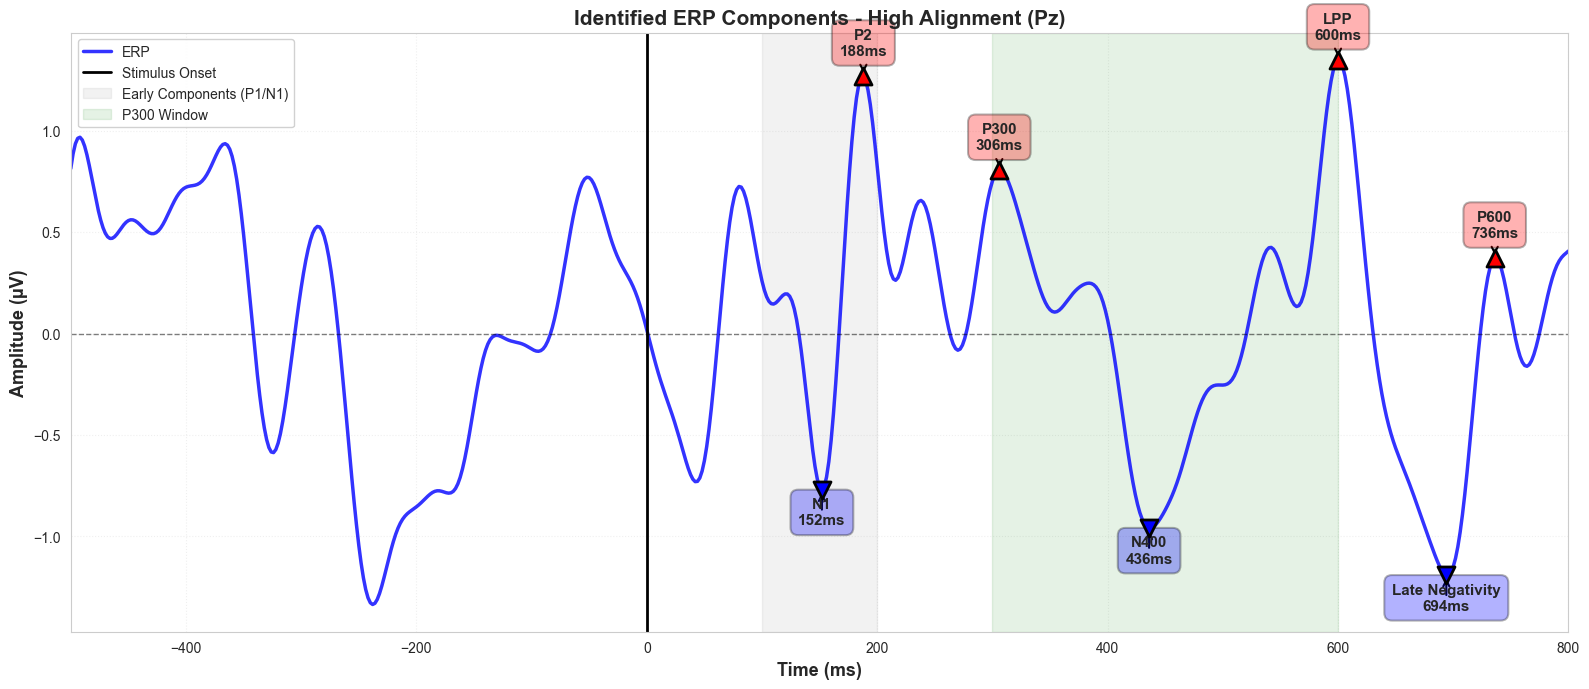

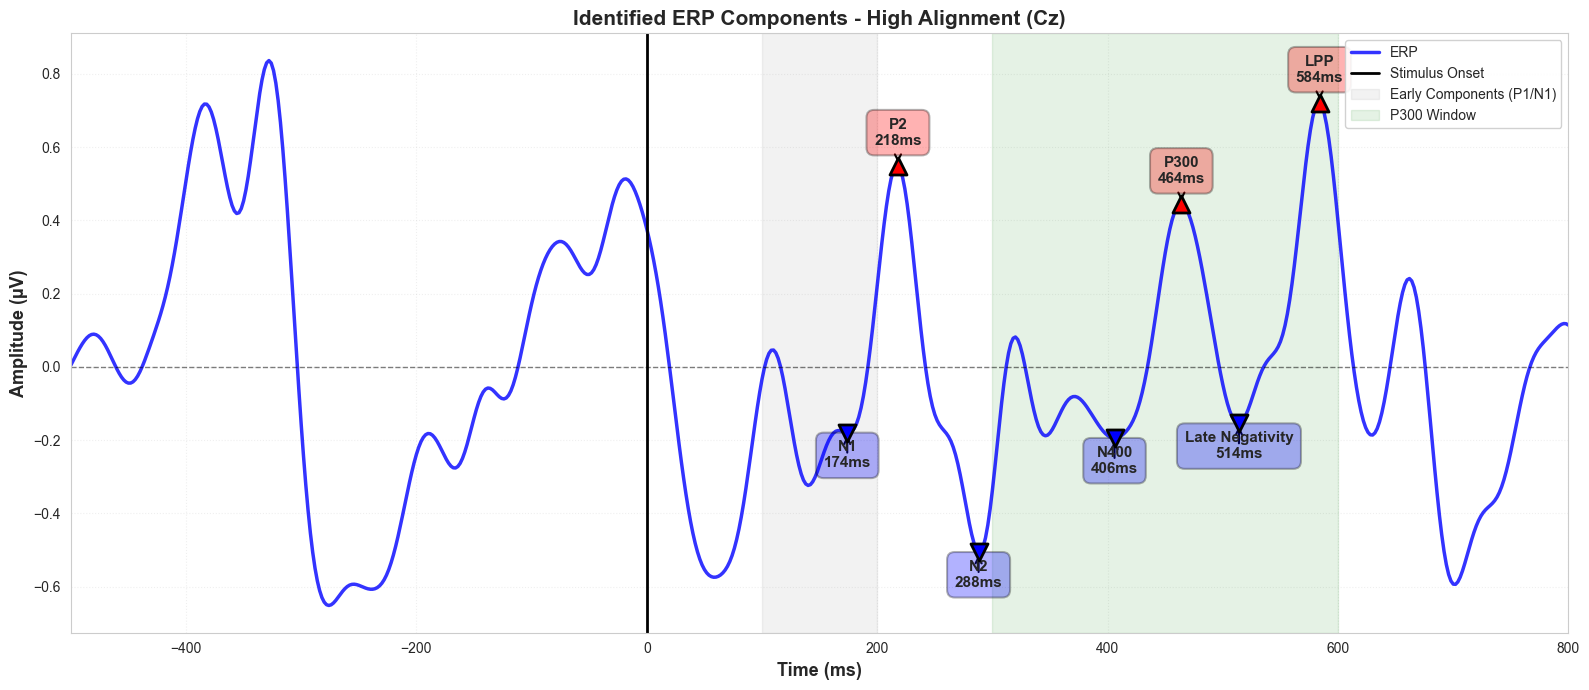

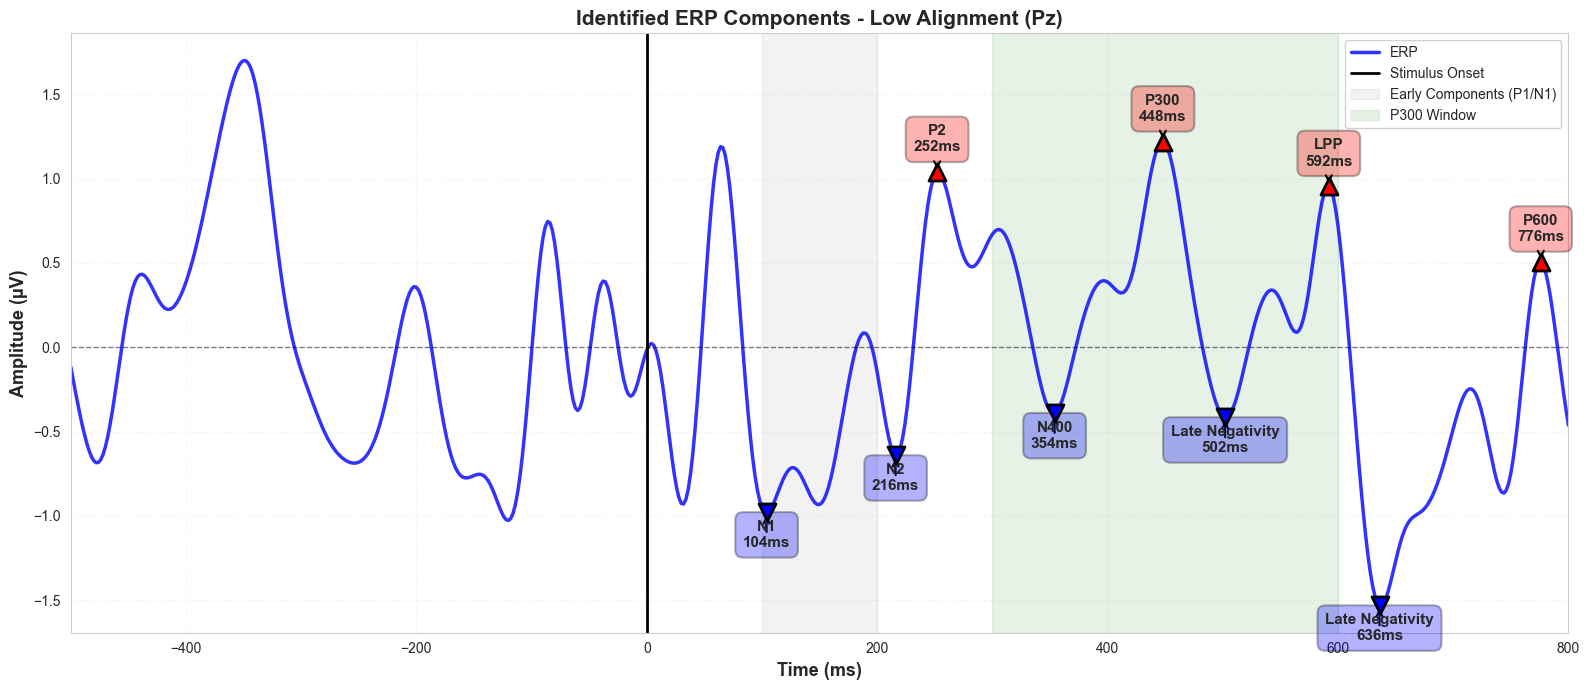

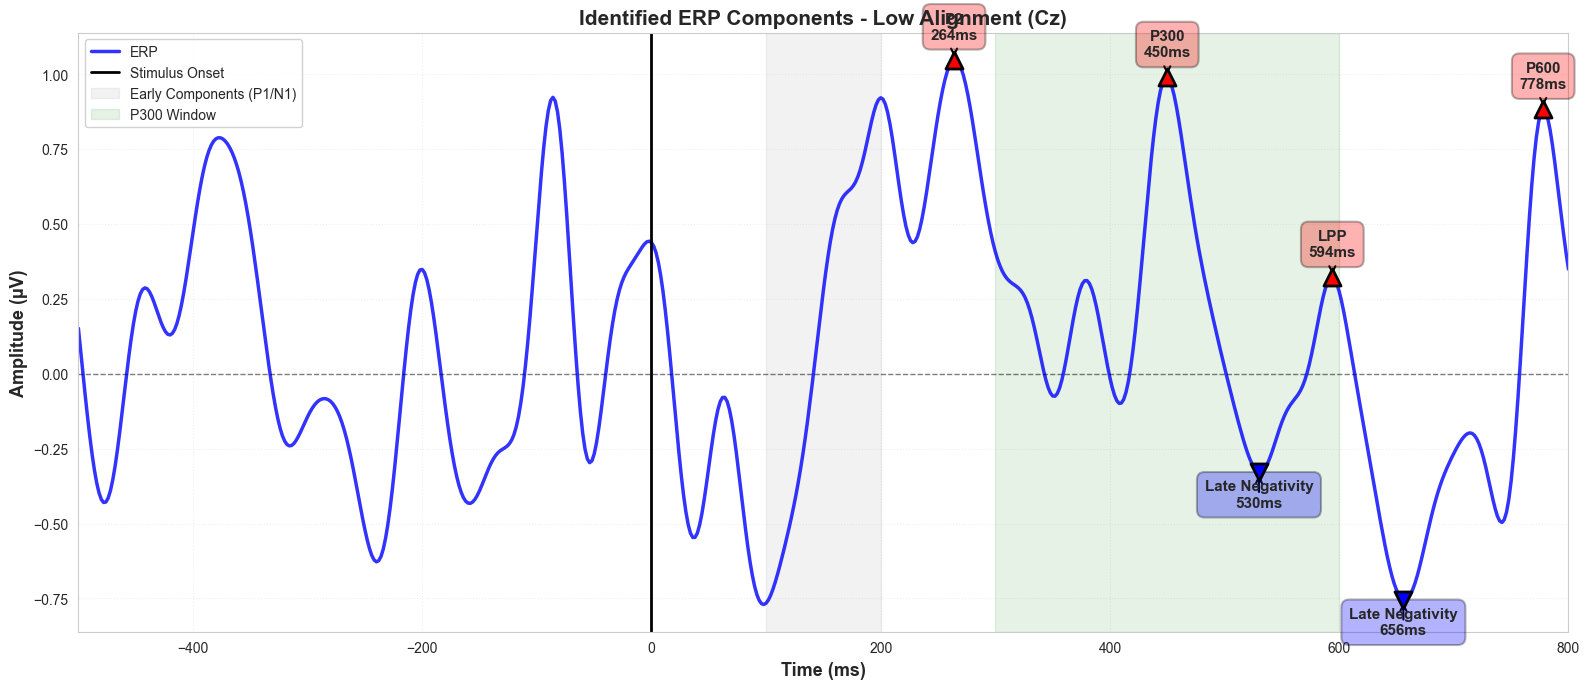

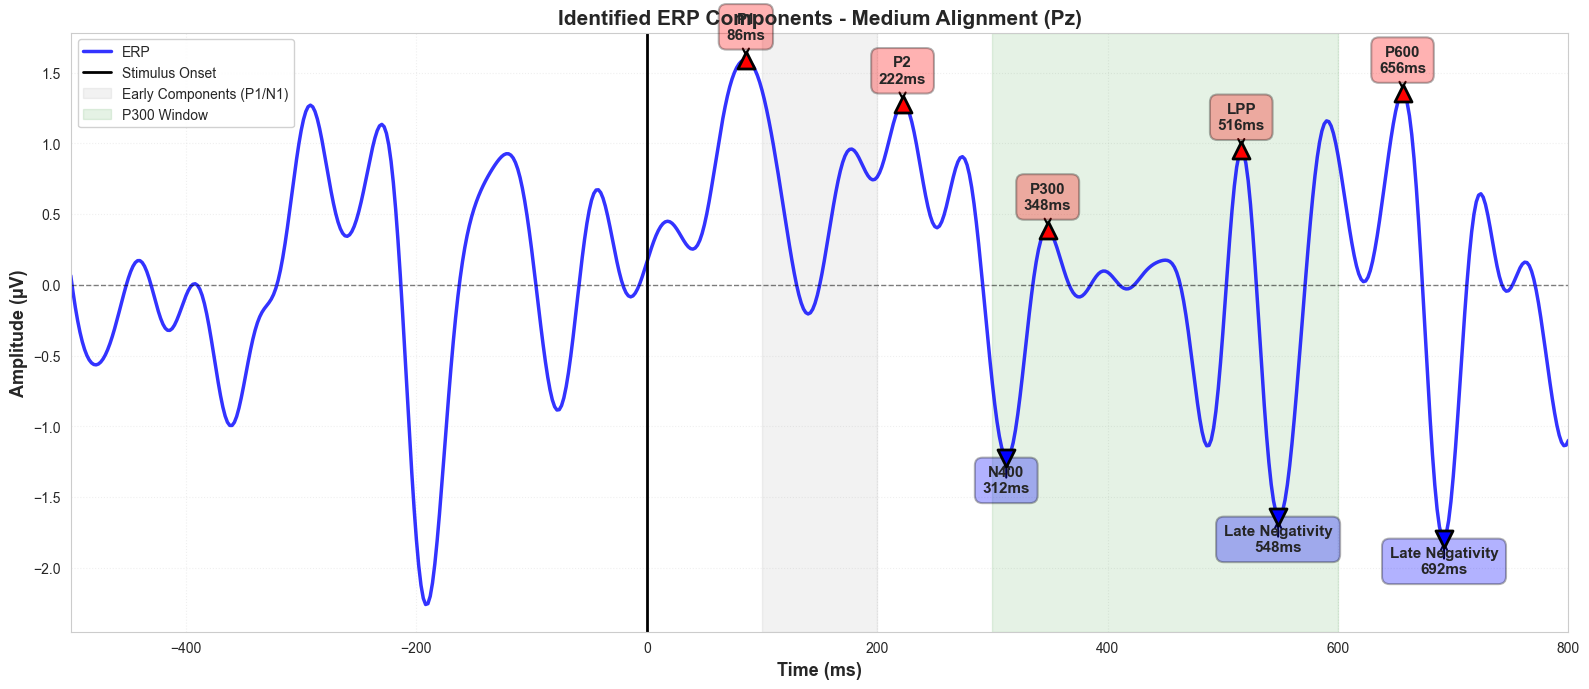

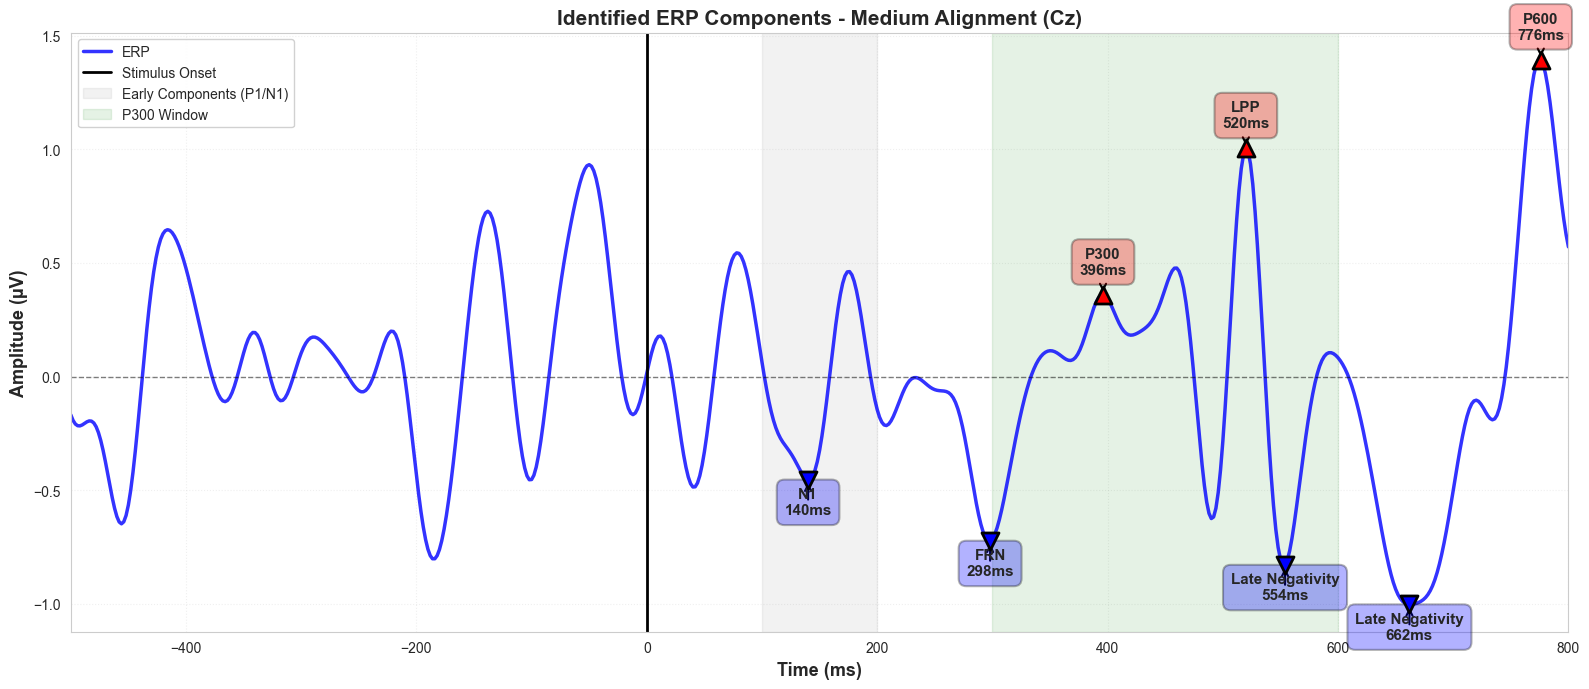

In [10]:
# Visualize identified components with labels
if identified_components:
    # Group by condition
    for condition_name in df_identified['Condition'].unique():
        df_cond = df_identified[df_identified['Condition'] == condition_name]
        
        # Get the evoked object for this condition
        evoked = None
        if condition_name == 'High':
            evoked = evoked_high
        elif condition_name == 'Medium':
            evoked = evoked_medium
        elif condition_name == 'Low':
            evoked = evoked_low
        
        if evoked is None:
            continue
        
        # Plot for Pz and Cz
        for channel in ['Pz', 'Cz']:
            if channel not in evoked.ch_names:
                continue
            
            df_ch = df_cond[df_cond['Channel'] == channel]
            if len(df_ch) == 0:
                continue
            
            fig, ax = plt.subplots(figsize=(16, 7))
            
            # Plot ERP
            ch_idx = evoked.ch_names.index(channel)
            times_ms = evoked.times * 1000
            data_uv = evoked.data[ch_idx, :] * 1e6
            ax.plot(times_ms, data_uv, 'b-', linewidth=2.5, label='ERP', alpha=0.8)
            
            # Mark and label identified components
            colors = {'Positive': 'red', 'Negative': 'blue'}
            markers = {'Positive': '^', 'Negative': 'v'}
            
            for _, row in df_ch.iterrows():
                color = colors[row['Polarity']]
                marker = markers[row['Polarity']]
                
                # Plot peak
                ax.scatter(row['Latency_ms'], row['Amplitude_uV'], 
                          color=color, s=150, marker=marker, zorder=5,
                          edgecolors='black', linewidths=2)
                
                # Add component label
                y_offset = 15 if row['Polarity'] == 'Positive' else -25
                label_text = f"{row['Identified_As']}\n{row['Latency_ms']:.0f}ms"
                
                ax.annotate(label_text,
                           xy=(row['Latency_ms'], row['Amplitude_uV']),
                           xytext=(0, y_offset),
                           textcoords='offset points',
                           fontsize=11,
                           fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.5', 
                                   facecolor=color, 
                                   alpha=0.3,
                                   edgecolor='black',
                                   linewidth=1.5),
                           arrowprops=dict(arrowstyle='->', 
                                         connectionstyle='arc3,rad=0',
                                         color='black',
                                         linewidth=1.5),
                           ha='center')
            
            # Reference lines
            ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5)
            ax.axvline(0, color='k', linestyle='-', linewidth=2, label='Stimulus Onset')
            
            # Shade typical time windows for major components
            ax.axvspan(100, 200, alpha=0.1, color='gray', label='Early Components (P1/N1)')
            ax.axvspan(300, 600, alpha=0.1, color='green', label='P300 Window')
            
            # Formatting
            ax.set_xlabel('Time (ms)', fontsize=13, fontweight='bold')
            ax.set_ylabel('Amplitude (µV)', fontsize=13, fontweight='bold')
            ax.set_title(f'Identified ERP Components - {condition_name} Alignment ({channel})', 
                        fontsize=15, fontweight='bold')
            ax.legend(loc='best', fontsize=10, framealpha=0.9)
            ax.grid(True, alpha=0.3, linestyle=':')
            ax.set_xlim([times_ms[0], times_ms[-1]])
            
            plt.tight_layout()
            plt.show()
else:
    print("No components identified to visualize")

---
## 8️⃣ VALIDATION: ERP Data Quality Assessment

**What it does**: Checks ERP data quality on multiple dimensions
**Quality checks**: 
- Amplitude range (typical: 5-30 µV)
- Baseline stability
- Signal-to-noise ratio
- Epoch count (minimum 15-20 recommended)
**Output**: Quality flags and interpretation recommendations


In [11]:
def assess_erp_quality(evoked, condition_name):
    """
    Assess ERP data quality based on neurophysiological plausibility.
    
    Returns quality report with warnings and recommendations.
    """
    if evoked is None:
        return None
    
    quality_report = {
        'condition': condition_name,
        'warnings': [],
        'recommendations': [],
        'is_valid': True
    }
    
    # Check 1: Amplitude range (should be ~5-30 µV for most components)
    data_uv = evoked.data * 1e6  # Convert to µV
    max_amp = np.max(np.abs(data_uv))
    mean_amp = np.mean(np.abs(data_uv))
    
    if max_amp > 50:
        quality_report['warnings'].append(
            f"⚠️ CRITICAL: Maximum amplitude {max_amp:.1f} µV exceeds typical range (5-30 µV). "
            f"Likely artifacts present (movement, muscle, poor electrode contact)."
        )
        quality_report['is_valid'] = False
        quality_report['recommendations'].append(
            "→ Check preprocessing: baseline correction, artifact rejection, referencing"
        )
    
    if max_amp > 100:
        quality_report['warnings'].append(
            f"⚠️ SEVERE: Amplitude {max_amp:.1f} µV is extremely high. "
            f"Data may be unusable without reprocessing."
        )
    
    # Check 2: Signal-to-noise ratio (smoothness)
    # Calculate variance of derivative as roughness measure
    for ch_idx in range(min(3, evoked.data.shape[0])):  # Check first 3 channels
        derivative = np.diff(evoked.data[ch_idx, :])
        roughness = np.std(derivative) / (np.std(evoked.data[ch_idx, :]) + 1e-10)
        
        if roughness > 0.15:
            quality_report['warnings'].append(
                f"⚠️ High-frequency noise detected in {evoked.ch_names[ch_idx]} (roughness={roughness:.3f}). "
                f"Signal appears 'jagged' rather than smooth."
            )
            quality_report['is_valid'] = False
            quality_report['recommendations'].append(
                f"→ Apply low-pass filter (e.g., 30 Hz) or increase averaging (more epochs)"
            )
            break
    
    # Check 3: Number of averaged epochs (from evoked.nave)
    n_epochs = evoked.nave
    if n_epochs < 15:
        quality_report['warnings'].append(
            f"⚠️ Only {n_epochs} epochs averaged. Minimum 15-20 recommended for stable ERPs."
        )
        quality_report['is_valid'] = False
        quality_report['recommendations'].append(
            "→ Collect more trials or relax artifact rejection criteria"
        )
    elif n_epochs < 30:
        quality_report['warnings'].append(
            f"ℹ️ {n_epochs} epochs averaged. 30+ recommended for robust results."
        )
    
    # Check 4: Baseline stability
    baseline_data = evoked.copy().crop(tmin=-0.2, tmax=0)
    baseline_std = np.std(baseline_data.data * 1e6)
    
    if baseline_std > 10:
        quality_report['warnings'].append(
            f"⚠️ Baseline period shows high variability (SD={baseline_std:.1f} µV). "
            f"Baseline correction may have failed."
        )
        quality_report['is_valid'] = False
        quality_report['recommendations'].append(
            "→ Verify baseline correction was applied correctly"
        )
    
    # Summary
    if quality_report['is_valid']:
        quality_report['summary'] = "✅ Data quality appears acceptable for ERP analysis"
    else:
        quality_report['summary'] = "❌ Data quality issues detected - interpret results with caution"
    
    return quality_report

# Assess quality for all conditions
print("="*100)
print("ERP DATA QUALITY ASSESSMENT")
print("="*100)

all_quality_reports = []

for condition_name, evoked in [('High', evoked_high), ('Medium', evoked_medium), ('Low', evoked_low)]:
    if evoked is not None:
        print(f"\n{'='*100}")
        print(f"Condition: {condition_name} Alignment")
        print(f"{'='*100}")
        
        report = assess_erp_quality(evoked, condition_name)
        all_quality_reports.append(report)
        
        # Print summary
        print(f"\n{report['summary']}")
        print(f"\nNumber of averaged epochs: {evoked.nave}")
        
        data_uv = evoked.data * 1e6
        print(f"Amplitude range: {np.min(data_uv):.1f} to {np.max(data_uv):.1f} µV")
        print(f"Mean absolute amplitude: {np.mean(np.abs(data_uv)):.1f} µV")
        
        # Print warnings
        if report['warnings']:
            print(f"\n⚠️ WARNINGS ({len(report['warnings'])}):")
            for warning in report['warnings']:
                print(f"  {warning}")
        
        # Print recommendations
        if report['recommendations']:
            print(f"\n💡 RECOMMENDATIONS:")
            for rec in report['recommendations']:
                print(f"  {rec}")

print(f"\n{'='*100}")
print("OVERALL ASSESSMENT")
print(f"{'='*100}")

valid_conditions = [r['condition'] for r in all_quality_reports if r['is_valid']]
invalid_conditions = [r['condition'] for r in all_quality_reports if not r['is_valid']]

if valid_conditions:
    print(f"\n✅ Valid for analysis: {', '.join(valid_conditions)}")
if invalid_conditions:
    print(f"\n❌ Quality issues detected: {', '.join(invalid_conditions)}")
    print(f"\n⚠️ CRITICAL: Peak detection and component identification may be unreliable for these conditions!")
    print(f"   Identified 'components' in poor-quality data likely represent:")
    print(f"   • Artifacts (movement, muscle, eye blinks)")
    print(f"   • Noise peaks rather than neural activity")
    print(f"   • Random fluctuations due to insufficient averaging")

print(f"\n{'='*100}")

ERP DATA QUALITY ASSESSMENT

Condition: High Alignment

✅ Data quality appears acceptable for ERP analysis

Number of averaged epochs: 17
Amplitude range: -2.5 to 2.7 µV
Mean absolute amplitude: 0.5 µV

⚠️ WARNINGS (1):
  ℹ️ 17 epochs averaged. 30+ recommended for robust results.

Condition: Medium Alignment

✅ Data quality appears acceptable for ERP analysis

Number of averaged epochs: 16
Amplitude range: -3.9 to 3.0 µV
Mean absolute amplitude: 0.6 µV

⚠️ WARNINGS (1):
  ℹ️ 16 epochs averaged. 30+ recommended for robust results.

Condition: Low Alignment

✅ Data quality appears acceptable for ERP analysis

Number of averaged epochs: 15
Amplitude range: -2.6 to 2.4 µV
Mean absolute amplitude: 0.5 µV

⚠️ WARNINGS (1):
  ℹ️ 15 epochs averaged. 30+ recommended for robust results.

OVERALL ASSESSMENT

✅ Valid for analysis: High, Medium, Low



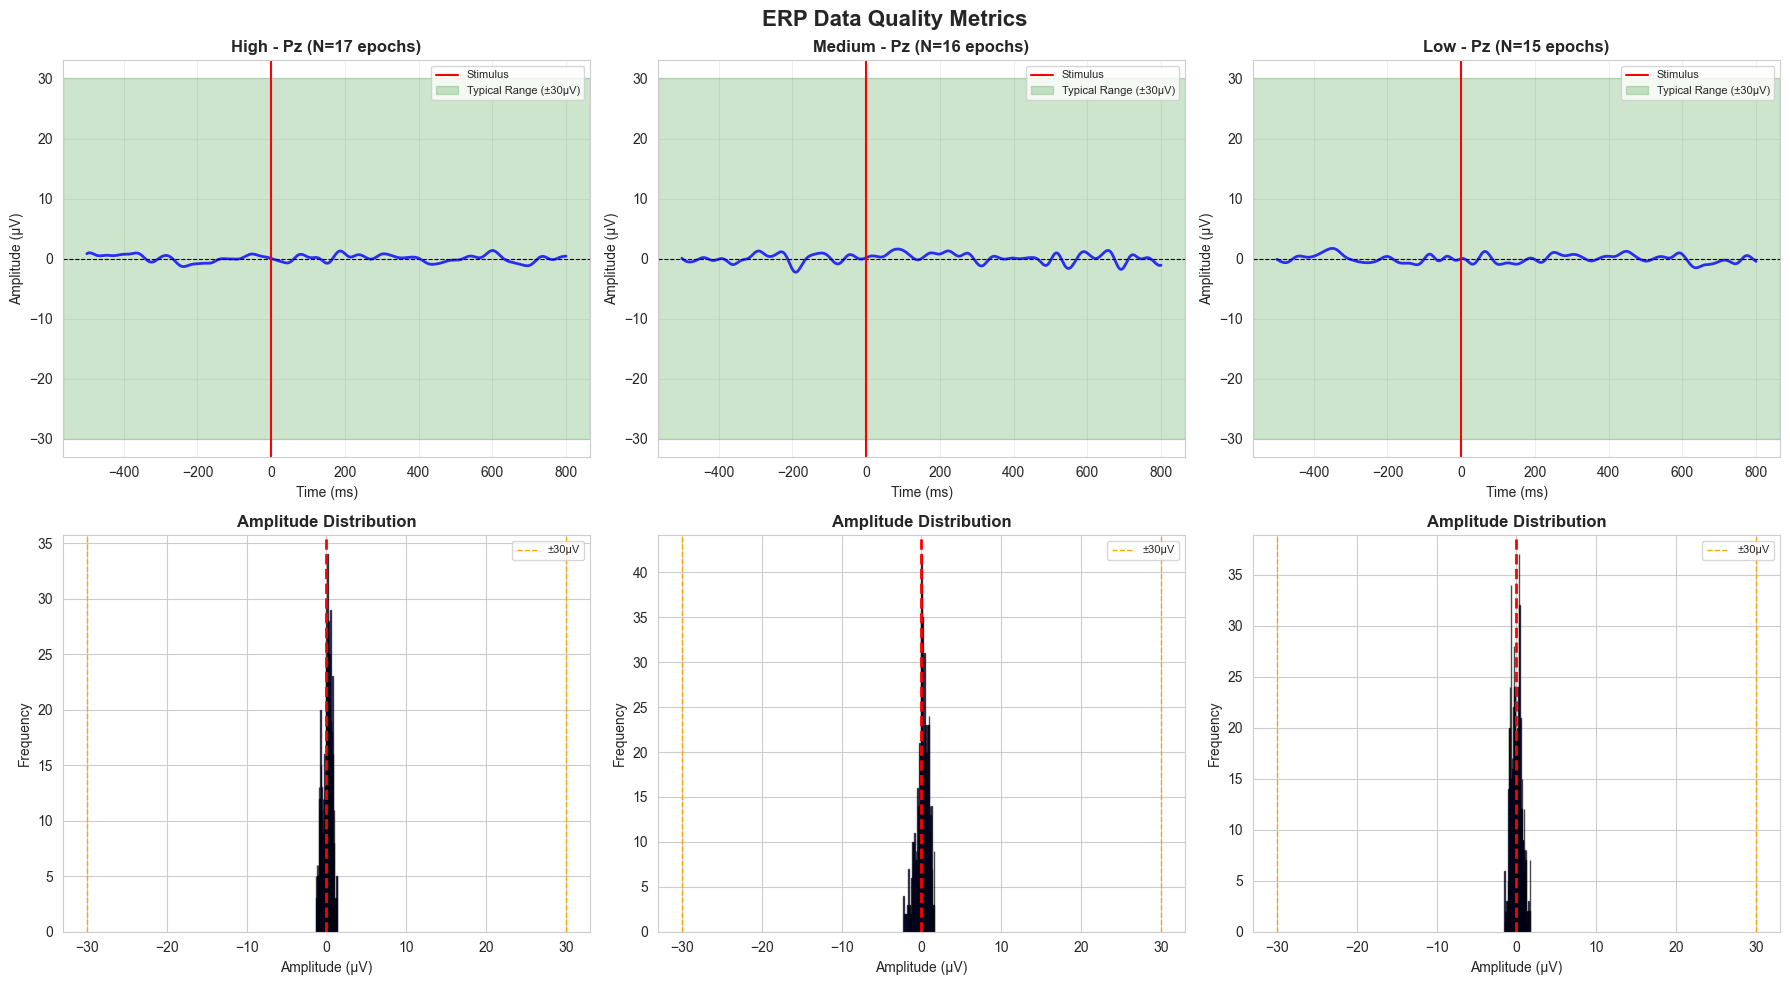


QUALITY STATISTICS SUMMARY
Condition  N_Epochs  Min_Amp_µV  Max_Amp_µV  Mean_Abs_µV    SD_µV Quality
     High        17   -2.465821    2.718779     0.474490 0.612376       ✅
   Medium        16   -3.861397    2.970681     0.567194 0.746654       ✅
      Low        15   -2.619737    2.418077     0.463524 0.587118       ✅

✓ Quality report saved to: ./results/erp_quality_session_20.csv


In [12]:
# Visualize quality metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ERP Data Quality Metrics', fontsize=16, fontweight='bold')

for idx, (condition_name, evoked) in enumerate([('High', evoked_high), ('Medium', evoked_medium), ('Low', evoked_low)]):
    if evoked is None:
        continue
    
    # Get Pz channel
    if 'Pz' in evoked.ch_names:
        ch_idx = evoked.ch_names.index('Pz')
        times_ms = evoked.times * 1000
        data_uv = evoked.data[ch_idx, :] * 1e6
        
        # Plot 1: ERP waveform with quality overlay
        ax = axes[0, idx]
        ax.plot(times_ms, data_uv, 'b-', linewidth=2, alpha=0.8)
        ax.axhline(0, color='k', linestyle='--', linewidth=0.8)
        ax.axvline(0, color='r', linestyle='-', linewidth=1.5, label='Stimulus')
        
        # Shade acceptable amplitude range
        ax.axhspan(-30, 30, alpha=0.2, color='green', label='Typical Range (±30µV)')
        
        # Mark if exceeds range
        if np.max(np.abs(data_uv)) > 50:
            ax.axhspan(-50, 50, alpha=0.15, color='orange', label='Warning (±50µV)')
        if np.max(np.abs(data_uv)) > 100:
            ax.axhspan(-100, 100, alpha=0.1, color='red', label='Critical (±100µV)')
        
        ax.set_title(f'{condition_name} - Pz (N={evoked.nave} epochs)', fontweight='bold')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Amplitude (µV)')
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Amplitude distribution
        ax = axes[1, idx]
        ax.hist(data_uv, bins=50, alpha=0.7, color='blue', edgecolor='black')
        ax.axvline(0, color='r', linestyle='--', linewidth=2)
        ax.axvline(-30, color='orange', linestyle='--', linewidth=1, label='±30µV')
        ax.axvline(30, color='orange', linestyle='--', linewidth=1)
        ax.set_title(f'Amplitude Distribution', fontweight='bold')
        ax.set_xlabel('Amplitude (µV)')
        ax.set_ylabel('Frequency')
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Summary statistics table
quality_stats = []
for condition_name, evoked in [('High', evoked_high), ('Medium', evoked_medium), ('Low', evoked_low)]:
    if evoked is not None:
        data_uv = evoked.data * 1e6
        quality_stats.append({
            'Condition': condition_name,
            'N_Epochs': evoked.nave,
            'Min_Amp_µV': np.min(data_uv),
            'Max_Amp_µV': np.max(data_uv),
            'Mean_Abs_µV': np.mean(np.abs(data_uv)),
            'SD_µV': np.std(data_uv),
            'Quality': '✅' if all_quality_reports[[r['condition'] for r in all_quality_reports].index(condition_name)]['is_valid'] else '❌'
        })

if quality_stats:
    df_quality = pd.DataFrame(quality_stats)
    print("\n" + "="*100)
    print("QUALITY STATISTICS SUMMARY")
    print("="*100)
    print(df_quality.to_string(index=False))
    
    # Save quality report
    df_quality.to_csv(f'./results/erp_quality_session_{session_id:02d}.csv', index=False)
    print(f"\n✓ Quality report saved to: ./results/erp_quality_session_{session_id:02d}.csv")

---

## 📋 REFERENCE: Output Files & What They Mean

### 📊 Figures (Publication-Ready)
| File | What It Shows | Use Case |
|------|---------------|----------|
| **Figure1a_erp_comparison_overlaid.png** | All 3 conditions overlaid at Pz & Fz | Main comparison figure |
| **Figure1b_erp_detailed_breakdown.png** | 3×3 grid: 3 electrodes × 3 conditions | Detailed supplementary figure |
| **Figure2_erp_difference_waves.png** | Difference waves (High - Low) across electrodes | Show condition-dependent modulation |
| **Figure3_erp_amplitude_comparison.png** | Bar plots with 95% CI and Cohen's d | Statistical summary for thesis |
| **Topo_[condition]_alignment.png** | Spatial distribution at 100, 200, 300, 500ms | Topographic supplement |

### 📈 Data Tables (CSV Format)
| File | Content | Key Columns |
|------|---------|------------|
| **erp_amplitude_comparison.csv** | Mean & peak amplitudes by condition & component | Component, Electrode, Low_Mean, Medium_Mean, High_Mean |
| **erp_statistical_comparison.csv** | Kruskal-Wallis & effect sizes | Component, H_Statistic, p_value, Eta_Squared |
| **erp_effect_sizes_cohens_d.csv** | Cohen's d effect sizes (High vs Low) | Component, Electrode, Cohens_d, Sample_Sizes |
| **erp_peaks_session_XX.csv** | Detected peaks per session | Channel, Latency_ms, Amplitude_µV, Polarity |
| **erp_identified_session_XX.csv** | Component identification with confidence | Component, Channel, Latency, Confidence |
| **erp_quality_session_XX.csv** | Data quality metrics | N_Epochs, Min/Max_Amplitude, Mean_Amplitude |

### 🧠 ERP Components Guide
| Component | Latency | Polarity | Electrode | Meaning |
|-----------|---------|----------|-----------|---------|
| **P300** | 300-600ms | Positive ↑ | Pz (parietal) | Context updating, attention allocation |
| **N400** | 300-500ms | Negative ↓ | Cz (central) | Semantic processing, expectancy violation |
| **P600** | 500-900ms | Positive ↑ | Pz (parietal) | Post-semantic processing, schema update |
| **FRN** | 250-350ms | Negative ↓ | Cz (central) | Feedback-related negativity, reward evaluation |
| **N2** | 200-350ms | Negative ↓ | Fz (frontal) | Conflict monitoring, cognitive control |
| **N1** | 80-150ms | Negative ↓ | Oz (occipital) | Visual attention, discrimination |

### 🔍 How to Interpret Your Results

**Confidence Intervals (Error bars in Figure 3):**
- Wider bars = more variability across sessions
- Non-overlapping bars = likely significant differences
- Check p-value for confirmation (p < 0.05 = significant)

**Cohen's d Effect Sizes:**
- |d| < 0.20 = Small effect
- 0.20 ≤ |d| < 0.50 = Small-to-moderate effect
- 0.50 ≤ |d| < 0.80 = Moderate-to-large effect  
- |d| ≥ 0.80 = Large effect

**Sample Size (n in Figure 3):**
- Shows how many sessions contributed to each bar
- Larger n = more robust estimate
- If n < 10, interpret cautiously

---

## ❓ Frequently Asked Questions

**Q: Why are my FRN/N400 values negative?**
A: Because they're negative ERP components! The y-axis shows actual polarity (negative down). This is correct.

**Q: Should I report p-values or effect sizes?**
A: Both! Modern science prefers effect sizes (Cohen's d) but p-values provide statistical confirmation.

**Q: Why are some components missing?**
A: Not all components are present in all subjects/conditions. Check quality flags and sample sizes.

**Q: Can I change the time windows?**
A: Yes! Edit the tuples in `key_components` list (lines ~1316). Format: (name, tmin, tmax, electrode, polarity)

**Q: What if data quality is poor?**
A: Check the quality assessment section (8️⃣). If amplitude > 50µV or n_epochs < 15, increase data collection or relax artifact rejection.

---
